In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import core.utils as utils
import core.wcrg as wcrg
import core.macro as macro
import core.bayes as bayes

In [65]:
x = np.load('data/weak_lensing.npy')
x = utils.preprocessing_weak_lensing(x)
x = torch.tensor(x)

In [67]:
s = x
d = s + torch.randn(*s.shape)
torch.save((s, d), 'data/weak_lensing.pt')

In [2]:
s, d = torch.load('data/weak_lensing.pt')
s, d = s.cuda(), d.cuda()

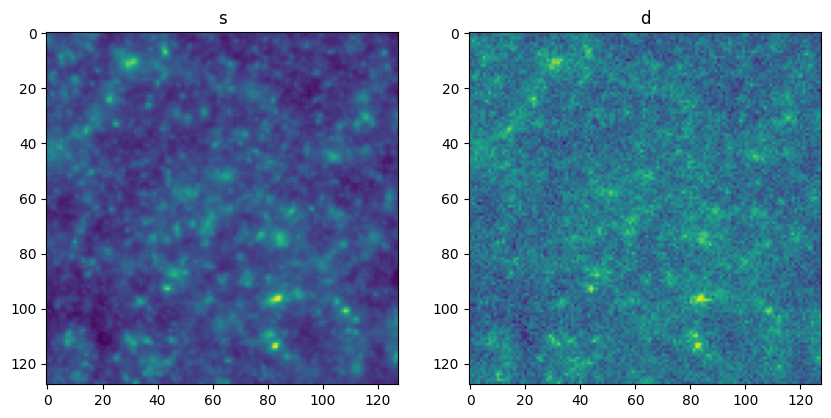

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(s[0].cpu())
ax2.imshow(d[0].cpu())
ax1.set_title("s")
ax2.set_title("d")
plt.show()

## Macro-canonical denoising learning

The algorithm is described in the report. Since large scales are denoised well by standard methods, we learn only a conditional model for scales L = 32, 64, 128, that are able to restore complete picture from a denoised L = 16 coarse-grained one.

During the algorithm we need to estimate pixelwise distribution of clean images. In order to do that, based on the form of the distribution we fit the following model
$$
    p_\theta(s) = \begin{cases}
        \alpha\exp\left[-\frac{(s - s_0)^2}{2\sigma^2}\right],\quad s_1\leq s\leq s_2\\
        \alpha\exp\left[-\frac{(s_1 - s_0)^2}{2\sigma^2}\right] e^{k_1(s - s_1)},\quad s < s_1\\
        \alpha\exp\left[-\frac{(s_2 - s_0)^2}{2\sigma^2}\right] e^{k_2(s_2 - s)},\quad s > s_2
    \end{cases}
$$

Based on continuity of derivative $dp_\theta/ds$ we can set $k_1 = (s_0 - s_1) / \sigma^2$ and $k_2 = (s_2 - s_0) / \sigma^2$. The value $\alpha$ is set by condition $\int p_\theta(s) ds = 1$. Therefore, there are 4 free parameters $\theta = \{\sigma, s_0, s_1, s_2\}$. Since we are in posession of noisy pixels of $d$ only, we can compute in analytical form 
$$
    p_\theta(d) = \int p_\theta(s) p_n(d - s) ds = \int p_\theta(s) \frac{1}{\sqrt{2\pi}}e^{-(d - s)^2 / 2} ds
$$
and then fit $\theta$ using max-likelihood method $\mathcal{L}(\theta) = \langle\log p_\theta(d)\rangle_{d\sim p_{\text{emp}}(d)}\to\max$, where by $d$ here we mean a noisy pixel, not the whole picture.

We note in advance, that, unfortunately, this method has numerical instabilities which we couldn't remove completely. We believe that the fits for L = 64 and L = 128 are not perfect and can be improved.

In [3]:
KEY = '128_weak_lensing'
dir_mod = 'logs/ansatz/'
dir_synth = 'logs/synthesis/'

m = 4
W = wcrg.Db_wavelets(m, device='cuda', mode='Periodic')

### L = 32

In [4]:
J = int(np.log2(d.shape[-1]))
L = 32

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s.float(), depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d.float(), depth, J, show_hist=False)

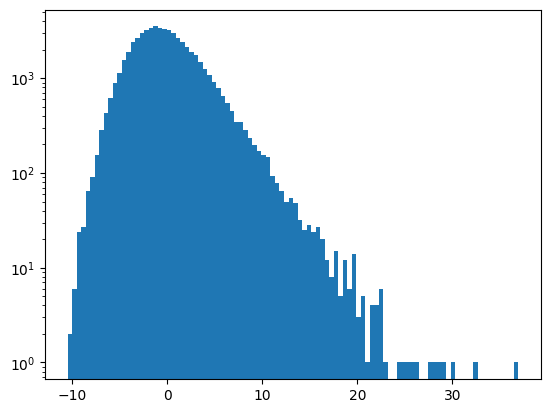

In [5]:
plt.hist(phi_d.flatten()[::100].cpu().reshape((-1)),bins=100)
plt.yscale('log')
plt.show()

In [6]:
mask = torch.bitwise_and(torch.max(phi_d.reshape(-1,(L*L)),1)[0]<25, torch.min(phi_d.reshape(-1,(L*L)),1)[0]>-10)
phi_d = phi_d[mask]
phi_s = phi_s[mask]
phi_d.shape, phi_s.shape

(torch.Size([4715, 32, 32]), torch.Size([4715, 32, 32]))

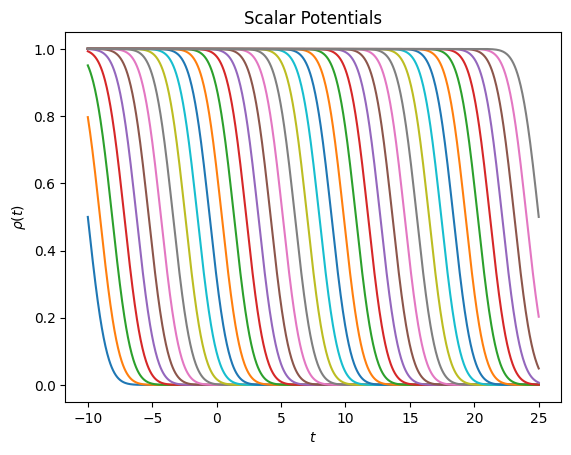

In [7]:
num_potentials = 38

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (0,2),(2,0),(2,2),(-2,2),
          (2,1),(1,2),(-1,2),(2,-1))

centers = torch.linspace(-10, 25, num_potentials).cuda()
sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

macro.Plot_NoiseSigmoid(centers, sigma)

mode = 'All'
ansatz = macro.NoiseANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)
clean_ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [8]:
data = torch.utils.data.DataLoader(phi_d[:1000].flatten(), batch_size = 102400, shuffle=True)
theta = torch.tensor([(phi_d.std()**2 - 1)**(1/2), 0, -5, 5], requires_grad=True)
optimizer = torch.optim.Adam([theta], lr=1e-1)

loss_list = []

for q in range(15):
    for x in data:
        optimizer.zero_grad()
        sigma, s0, s1, s2 = theta
        sigma_n = (sigma**2 + 1)**(1/2)
        k1 = (s0 - s1) / sigma**2
        k2 = (s2 - s0) / sigma**2
        
        c0 = (np.pi / 2)**(1/2) * sigma * (torch.erf((s2 - s0) / sigma / 2**(1/2)) - torch.erf((s1 - s0) / sigma / 2**(1/2)))
        c1 = torch.exp(-(s0 - s1)**2 / 2 / sigma**2) / k1
        c2 = torch.exp(-(s0 - s2)**2 / 2 / sigma**2) / k2
        
        p0 = sigma * torch.exp(-(x - s0)**2 / 2 / sigma_n**2) * (torch.erf((s2 - s0 + sigma**2 * (s2 - x)) / 2**(1/2) / sigma / sigma_n) - torch.erf((s1 - s0 + sigma**2 * (s1 - x)) / 2**(1/2) / sigma / sigma_n)) / 2 / sigma_n
        p1 = torch.exp((k1 * (2 * x + k1 - 2 * s1) - (s0 - s1)**2 / sigma**2) / 2) * torch.erfc((x + k1 - s1) / 2**(1/2)) / 2
        p2 = torch.exp((k2 * (2 * s2 + k2 - 2 * x) - (s0 - s2)**2 / sigma**2) / 2) * torch.erfc((k2 + s2 - x) / 2**(1/2)) / 2
        p = (p0 + p1 + p2) / (c0 + c1 + c2)
        
        loss = -torch.log(p).mean()
        loss.backward()
        optimizer.step()
        
        loss_list.append((loss.item(), theta.detach().clone()))

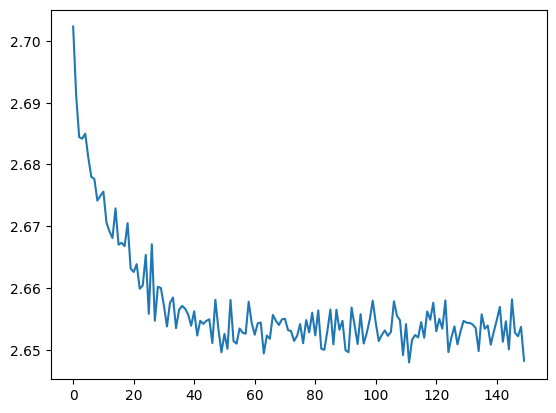

In [9]:
plt.plot([x[0] for x in loss_list])
plt.show()

In [10]:
with torch.no_grad():
    n = 100000
    sigma, s0, s1, s2 = theta
    choice = torch.rand(n)

    mask1 = choice < c1 / (c0 + c1 + c2)
    mask2 = choice > (c0 + c1) / (c0 + c1 + c2)
    mask0 = torch.bitwise_not(torch.bitwise_or(mask1, mask2))

    n1 = mask1.sum()
    n2 = mask2.sum()
    n0 = n - n1 - n2

    sample1 = s1 + torch.log(torch.rand(n1)) / k1
    sample2 = s2 - torch.log(torch.rand(n2)) / k2
    sample0 = s0 + sigma * torch.randn(int(2 * n0 * (c0 + c1 + c2) / c0))
    sample0 = sample0[torch.bitwise_and(s1 <= sample0, sample0 <= s2)]

    phi = torch.zeros(n, dtype=torch.float32)
    phi[mask0] = sample0[:n0]
    phi[mask1] = sample1
    phi[mask2] = sample2
    
    phi = phi.cuda()

/tmp/ipykernel_254089/1754960411.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_s_hist[:-1], np.log10(p_s_hist), 'bo')
/tmp/ipykernel_254089/1754960411.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_sample_hist[:-1], np.log10(p_sample_hist), 'go')


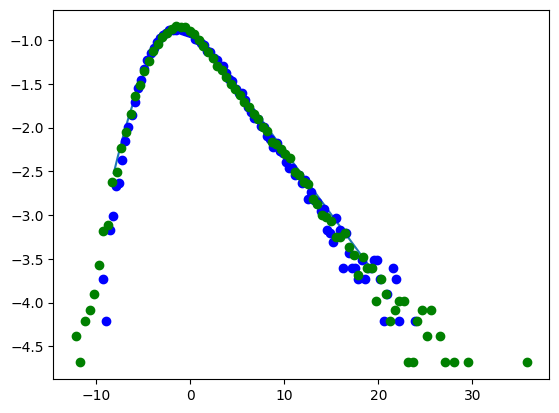

In [11]:
p_s_hist, x_s_hist = np.histogram(phi_s.flatten()[::100].cpu(), bins=100, density=True)
p_sample_hist, x_sample_hist = np.histogram(phi.cpu(), bins=100, density=True)

xx = x.detach().cpu().numpy()[::100]
pp = p.detach().cpu().numpy()[::100]
index = np.argsort(xx)

plt.plot(xx[index], np.log10(pp[index]))
plt.plot(x_s_hist[:-1], np.log10(p_s_hist), 'bo')
plt.plot(x_sample_hist[:-1], np.log10(p_sample_hist), 'go')
plt.show()

In [12]:
dataloader = torch.utils.data.DataLoader(phi_d[:1000], batch_size=100)
shift = macro.calculate_shift(clean_ansatz, ansatz, phi)
ansatz.rescale_theta = macro.calculate_rescale(clean_ansatz, dataloader, shift, mean_mode=False)

/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/

In [13]:
lr = 1e-2
momentum = 0
num_epochs = 10

optimizer = torch.optim.SGD([ansatz.theta_no_rescale], lr=lr, momentum=momentum)

for q in range(num_epochs):    
    for x in dataloader:
        theta = ansatz.theta()
        grad_mean, laplace_mean = clean_ansatz.compute_grad(x, None)
        
        evals, evecs = torch.linalg.eigh(grad_mean - shift)
        pos_evals = torch.clamp(evals, min=0)
        pos_grad = evecs @ torch.diag(pos_evals) @ evecs.T

        quad = torch.sum(pos_grad * theta[:, None] * theta[None, :])
        linear = torch.sum(laplace_mean * theta)
        loss = quad - 2 * linear

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print( '[{}/{}] loss: {:.8}'.format(q, num_epochs, loss.item()))

[0/10] loss: 0.0
[0/10] loss: -29.506756
[0/10] loss: -54.290062
[0/10] loss: -78.170547
[0/10] loss: -97.775169
[0/10] loss: -119.24159
[0/10] loss: -135.07887
[0/10] loss: -151.19028
[0/10] loss: -154.71024
[0/10] loss: -171.44342
[1/10] loss: -174.65683
[1/10] loss: -180.59888
[1/10] loss: -186.29276
[1/10] loss: -196.61174
[1/10] loss: -201.06277
[1/10] loss: -215.15718
[1/10] loss: -213.07678
[1/10] loss: -214.46611
[1/10] loss: -215.88264
[1/10] loss: -223.26303
[2/10] loss: -223.40858
[2/10] loss: -228.04501
[2/10] loss: -229.29921
[2/10] loss: -231.87823
[2/10] loss: -236.826
[2/10] loss: -245.17242
[2/10] loss: -241.56755
[2/10] loss: -239.42438
[2/10] loss: -239.3266
[2/10] loss: -240.05356
[3/10] loss: -241.87558
[3/10] loss: -240.60789
[3/10] loss: -248.06412
[3/10] loss: -244.6963
[3/10] loss: -249.75967
[3/10] loss: -260.1391
[3/10] loss: -252.46181
[3/10] loss: -253.17651
[3/10] loss: -250.04617
[3/10] loss: -252.18036
[4/10] loss: -255.43558
[4/10] loss: -254.11081
[4/1

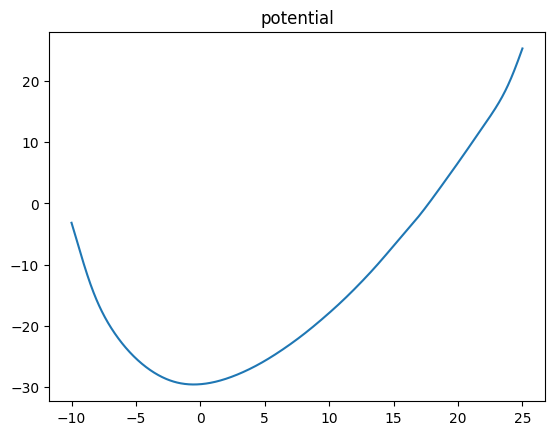

In [14]:
macro.Show_NoiseSigmoid(ansatz)

In [15]:
wcrg.save_ansatz(ansatz, L, KEY, dir_mod) 

### L = 64

In [16]:
J = int(np.log2(d.shape[-1]))
L = 64

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s.float(), depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d.float(), depth, J, show_hist=False)

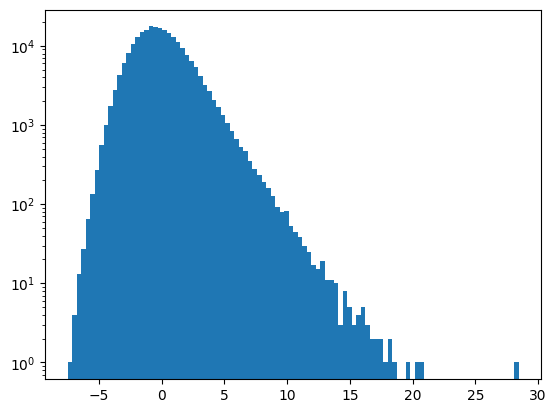

In [17]:
plt.hist(phi_d.flatten()[::100].cpu().reshape((-1)),bins=100)
plt.yscale('log')
plt.show()

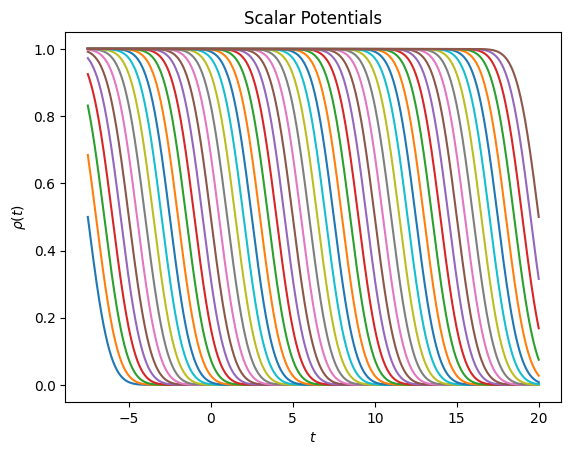

In [33]:
num_potentials = 56

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (2,0),(0,2),(2,2),(2,-2))

centers = torch.linspace(-7.5, 20, num_potentials).cuda()
sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

macro.Plot_NoiseSigmoid(centers, sigma)

mode = 'All'
ansatz = macro.NoiseANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)
clean_ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [ ]:
data = torch.utils.data.DataLoader(phi_d[:1000].flatten()[::4], batch_size = 51200, shuffle=True)
theta = torch.tensor([(phi_d.std()**2 - 1)**(1/2), 0, -5, 5], requires_grad=True)
optimizer = torch.optim.Adam([theta], lr=3e-2)

loss_list = []

for q in range(15):
    for x in data:
        optimizer.zero_grad()
        sigma, s0, s1, s2 = theta
        sigma_n = (sigma**2 + 1)**(1/2)
        k1 = (s0 - s1) / sigma**2
        k2 = (s2 - s0) / sigma**2
        
        c0 = (np.pi / 2)**(1/2) * sigma * (torch.erf((s2 - s0) / sigma / 2**(1/2)) - torch.erf((s1 - s0) / sigma / 2**(1/2)))
        c1 = torch.exp(-(s0 - s1)**2 / 2 / sigma**2) / k1
        c2 = torch.exp(-(s0 - s2)**2 / 2 / sigma**2) / k2
        
        p0 = sigma * torch.exp(-(x - s0)**2 / 2 / sigma_n**2) * (torch.erf((s2 - s0 + sigma**2 * (s2 - x)) / 2**(1/2) / sigma / sigma_n) - torch.erf((s1 - s0 + sigma**2 * (s1 - x)) / 2**(1/2) / sigma / sigma_n)) / 2 / sigma_n
        p1 = torch.where(x <= s1 + 2 * k1, 
                         torch.exp((k1 * (2 * x + k1 - 2 * s1) - (s0 - s1)**2 / sigma**2) / 2) * torch.erfc((x + k1 - s1) / 2**(1/2)) / 2,
                         0)
        p2 = torch.where(x >= s2 - 2 * k2,
                         torch.exp((k2 * (2 * s2 + k2 - 2 * x) - (s0 - s2)**2 / sigma**2) / 2) * torch.erfc((k2 + s2 - x) / 2**(1/2)) / 2,
                         0)
        p = (p0 + p1 + p2) / (c0 + c1 + c2)
        
        loss = -torch.log(p).mean()
        loss.backward()
        optimizer.step()
        
        loss_list.append((loss.item(), theta.detach().clone()))
        print(loss_list[-1])

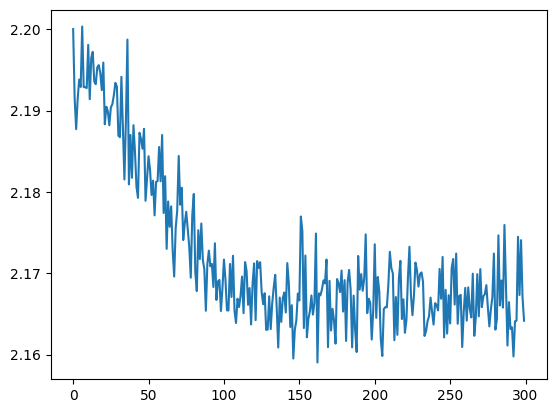

In [21]:
plt.plot([x[0] for x in loss_list])
plt.show()

In [22]:
with torch.no_grad():
    n = 100000
    sigma, s0, s1, s2 = theta
    choice = torch.rand(n)

    mask1 = choice < c1 / (c0 + c1 + c2)
    mask2 = choice > (c0 + c1) / (c0 + c1 + c2)
    mask0 = torch.bitwise_not(torch.bitwise_or(mask1, mask2))

    n1 = mask1.sum()
    n2 = mask2.sum()
    n0 = n - n1 - n2

    sample1 = s1 + torch.log(torch.rand(n1)) / k1
    sample2 = s2 - torch.log(torch.rand(n2)) / k2
    sample0 = s0 + sigma * torch.randn(int(2 * n0 * (c0 + c1 + c2) / c0))
    sample0 = sample0[torch.bitwise_and(s1 <= sample0, sample0 <= s2)]

    phi = torch.zeros(n, dtype=torch.float32)
    phi[mask0] = sample0[:n0]
    phi[mask1] = sample1
    phi[mask2] = sample2
    
    phi = phi.cuda()

/tmp/ipykernel_254089/1754960411.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_s_hist[:-1], np.log10(p_s_hist), 'bo')
/tmp/ipykernel_254089/1754960411.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_sample_hist[:-1], np.log10(p_sample_hist), 'go')


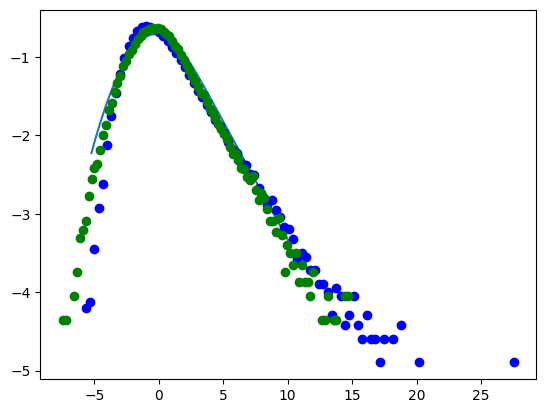

In [23]:
p_s_hist, x_s_hist = np.histogram(phi_s.flatten()[::100].cpu(), bins=100, density=True)
p_sample_hist, x_sample_hist = np.histogram(phi.cpu(), bins=100, density=True)

xx = x.detach().cpu().numpy()[::100]
pp = p.detach().cpu().numpy()[::100]
index = np.argsort(xx)

plt.plot(xx[index], np.log10(pp[index]))
plt.plot(x_s_hist[:-1], np.log10(p_s_hist), 'bo')
plt.plot(x_sample_hist[:-1], np.log10(p_sample_hist), 'go')
plt.show()

In [34]:
dataloader = torch.utils.data.DataLoader(phi_d[:1000], batch_size=50)
shift = macro.calculate_shift(clean_ansatz, ansatz, phi)
ansatz.rescale_theta = macro.calculate_rescale(clean_ansatz, dataloader, shift, mean_mode=False)

In [35]:
lr = 3e-3
momentum = 0
num_epochs = 10

optimizer = torch.optim.SGD([ansatz.theta_no_rescale], lr=lr, momentum=momentum)

for q in range(num_epochs):    
    for x in dataloader:
        theta = ansatz.theta()
        grad_mean, laplace_mean = clean_ansatz.compute_grad(x, None)
        
        evals, evecs = torch.linalg.eigh(grad_mean - shift)
        pos_evals = torch.clamp(evals, min=0)
        pos_grad = evecs @ torch.diag(pos_evals) @ evecs.T

        quad = torch.sum(pos_grad * theta[:, None] * theta[None, :])
        linear = torch.sum(laplace_mean * theta)
        loss = quad - 2 * linear

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print( '[{}/{}] loss: {:.8}'.format(q, num_epochs, loss.item()))

[0/10] loss: 0.0
[0/10] loss: -328.49924
[0/10] loss: -674.58508
[0/10] loss: -918.96527
[0/10] loss: -1164.5945
[0/10] loss: -1509.5078
[0/10] loss: -1675.1345
[0/10] loss: -1904.6899
[0/10] loss: -2155.3638
[0/10] loss: -2374.8018
[0/10] loss: -2505.4956
[0/10] loss: -2708.801
[0/10] loss: -2925.0117
[0/10] loss: -3130.7661
[0/10] loss: -3045.3291
[0/10] loss: -3166.2617
[0/10] loss: -3496.8752
[0/10] loss: -3592.2861
[0/10] loss: -3530.3762
[0/10] loss: -3792.7913
[1/10] loss: -3692.3633
[1/10] loss: -3973.5349
[1/10] loss: -4061.6035
[1/10] loss: -4195.0029
[1/10] loss: -4171.8955
[1/10] loss: -4390.7163
[1/10] loss: -4408.9224
[1/10] loss: -4490.1523
[1/10] loss: -4557.9619
[1/10] loss: -4629.585
[1/10] loss: -4703.1587
[1/10] loss: -4724.229
[1/10] loss: -4878.4497
[1/10] loss: -4804.8643
[1/10] loss: -3918.7661
[1/10] loss: -4968.7271
[1/10] loss: -5174.1201
[1/10] loss: -4995.4399
[1/10] loss: -4587.3472
[1/10] loss: -5101.5332
[2/10] loss: -5199.4893
[2/10] loss: -5097.1675
[2

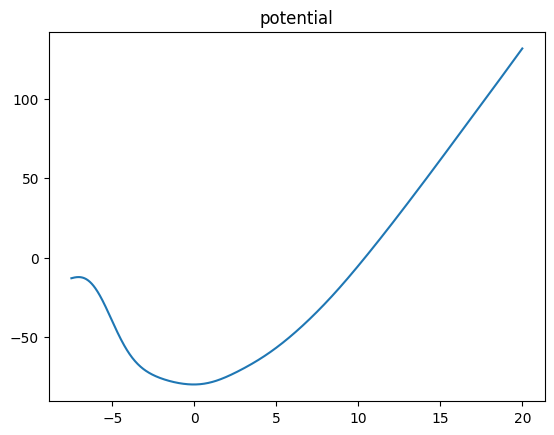

In [37]:
macro.Show_NoiseSigmoid(ansatz)

In [38]:
wcrg.save_ansatz(ansatz, L, KEY, dir_mod)

### L = 128

In [4]:
J = int(np.log2(d.shape[-1]))
L = 128

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s.float(), depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d.float(), depth, J, show_hist=False)

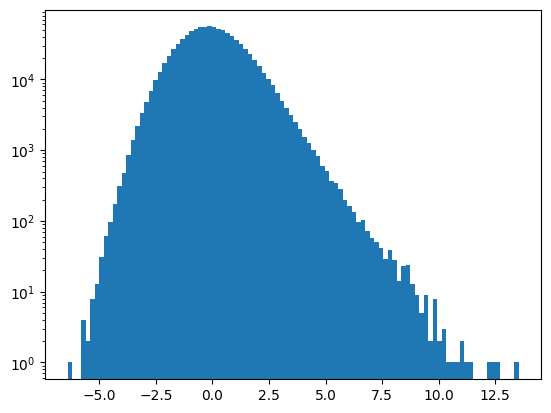

In [5]:
plt.hist(phi_d.flatten()[::100].cpu().reshape((-1)),bins=100)
plt.yscale('log')
plt.show()

In [5]:
mask = torch.bitwise_and(torch.max(phi_d.reshape(-1,(L*L)),1)[0]<10, torch.min(phi_d.reshape(-1,(L*L)),1)[0]>-5)
phi_d = phi_d[mask]
phi_s = phi_s[mask]
phi_d.shape, phi_s.shape

(torch.Size([3264, 128, 128]), torch.Size([3264, 128, 128]))

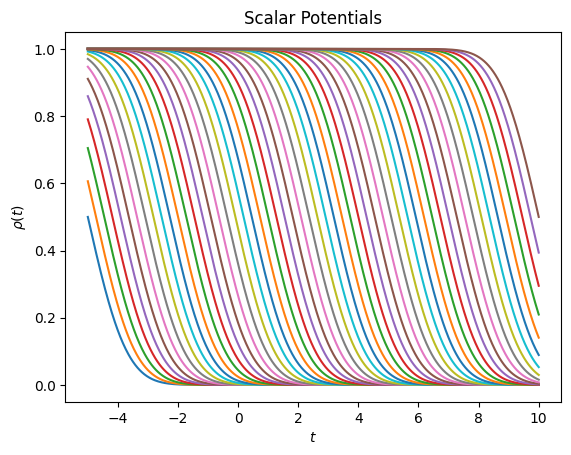

In [6]:
num_potentials = 56

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (2,0),(0,2),(2,2),(2,-2))

centers = torch.linspace(-5, 10, num_potentials).cuda()
sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

macro.Plot_NoiseSigmoid(centers, sigma)

mode = 'All'
ansatz = macro.NoiseANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)
clean_ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [15]:
torch.cuda.empty_cache()
!nvidia-smi

Wed Aug 23 10:23:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.203.08   Driver Version: 450.203.08   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   43C    P0    44W / 250W |   2915MiB / 32510MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [9]:
data = torch.utils.data.DataLoader(phi_d[:1000].flatten()[::16], batch_size = 102400, shuffle=True)
theta = torch.tensor([(phi_d.std()**2 - 1)**(1/2), 0, -2.5, 2.5], requires_grad=True)
optimizer = torch.optim.Adam([theta], lr=3e-2)

loss_list = []

for q in range(15):
    for x in data:
        optimizer.zero_grad()
        sigma, s0, s1, s2 = theta
        sigma_n = (sigma**2 + 1)**(1/2)
        k1 = (s0 - s1) / sigma**2
        k2 = (s2 - s0) / sigma**2
        
        c0 = (np.pi / 2)**(1/2) * sigma * (torch.erf((s2 - s0) / sigma / 2**(1/2)) - torch.erf((s1 - s0) / sigma / 2**(1/2)))
        c1 = torch.exp(-(s0 - s1)**2 / 2 / sigma**2) / k1
        c2 = torch.exp(-(s0 - s2)**2 / 2 / sigma**2) / k2
        
        p0 = sigma * torch.exp(-(x - s0)**2 / 2 / sigma_n**2) * (torch.erf((s2 - s0 + sigma**2 * (s2 - x)) / 2**(1/2) / sigma / sigma_n) - torch.erf((s1 - s0 + sigma**2 * (s1 - x)) / 2**(1/2) / sigma / sigma_n)) / 2 / sigma_n
        p1 = torch.where(x <= s1 + 1.5 * k1, 
                         torch.exp((k1 * (2 * x + k1 - 2 * s1) - (s0 - s1)**2 / sigma**2) / 2) * torch.erfc((x + k1 - s1) / 2**(1/2)) / 2,
                         0)
        p2 = torch.where(x >= s2 - 1.5 * k2,
                         torch.exp((k2 * (2 * s2 + k2 - 2 * x) - (s0 - s2)**2 / sigma**2) / 2) * torch.erfc((k2 + s2 - x) / 2**(1/2)) / 2,
                         0)
        p = (p0 + p1 + p2) / (c0 + c1 + c2)
        
        loss = -torch.log(p).mean()
        loss.backward()
        optimizer.step()
        
        loss_list.append((loss.item(), theta.detach().clone()))

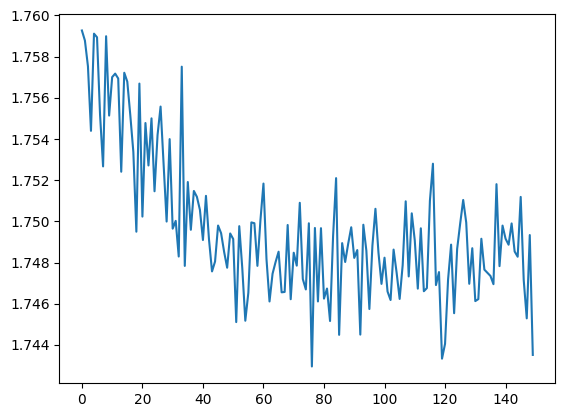

In [10]:
plt.plot([x[0] for x in loss_list])
plt.show()

In [11]:
with torch.no_grad():
    n = 100000
    sigma, s0, s1, s2 = theta
    choice = torch.rand(n)
    
    k1 = (s0 - s1) / sigma**2
    k2 = (s2 - s0) / sigma**2
    
    c0 = (np.pi / 2)**(1/2) * sigma * (torch.erf((s2 - s0) / sigma / 2**(1/2)) - torch.erf((s1 - s0) / sigma / 2**(1/2)))
    c1 = torch.exp(-(s0 - s1)**2 / 2 / sigma**2) / k1
    c2 = torch.exp(-(s0 - s2)**2 / 2 / sigma**2) / k2
    
    p0 = sigma * torch.exp(-(x - s0)**2 / 2 / sigma_n**2) * (torch.erf((s2 - s0 + sigma**2 * (s2 - x)) / 2**(1/2) / sigma / sigma_n) - torch.erf((s1 - s0 + sigma**2 * (s1 - x)) / 2**(1/2) / sigma / sigma_n)) / 2 / sigma_n
    p1 = torch.exp((k1 * (2 * x + k1 - 2 * s1) - (s0 - s1)**2 / sigma**2) / 2) * torch.erfc((x + k1 - s1) / 2**(1/2)) / 2
    p2 = torch.exp((k2 * (2 * s2 + k2 - 2 * x) - (s0 - s2)**2 / sigma**2) / 2) * torch.erfc((k2 + s2 - x) / 2**(1/2)) / 2

    p = (p0 + p1 + p2) / (c0 + c1 + c2)

    mask1 = choice < c1 / (c0 + c1 + c2)
    mask2 = choice > (c0 + c1) / (c0 + c1 + c2)
    mask0 = torch.bitwise_not(torch.bitwise_or(mask1, mask2))

    n1 = mask1.sum()
    n2 = mask2.sum()
    n0 = n - n1 - n2

    sample1 = s1 + torch.log(torch.rand(n1)) / k1
    sample2 = s2 - torch.log(torch.rand(n2)) / k2
    sample0 = s0 + sigma * torch.randn(int(2 * n0 * (c0 + c1 + c2) / c0))
    sample0 = sample0[torch.bitwise_and(s1 <= sample0, sample0 <= s2)]

    phi = torch.zeros(n, dtype=torch.float32)
    phi[mask0] = sample0[:n0]
    phi[mask1] = sample1
    phi[mask2] = sample2
    
    phi = phi.cuda()

/tmp/ipykernel_49453/1754960411.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_s_hist[:-1], np.log10(p_s_hist), 'bo')
/tmp/ipykernel_49453/1754960411.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_sample_hist[:-1], np.log10(p_sample_hist), 'go')


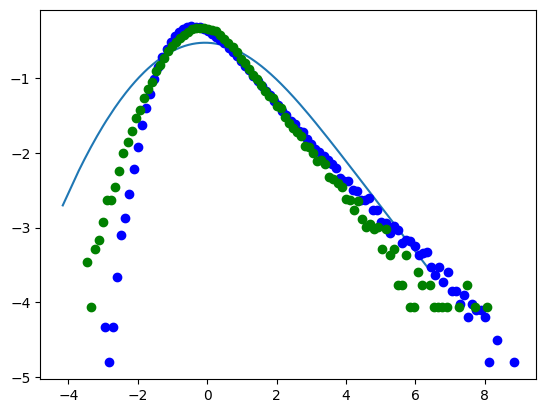

In [12]:
p_s_hist, x_s_hist = np.histogram(phi_s.flatten()[::100].cpu(), bins=100, density=True)
p_sample_hist, x_sample_hist = np.histogram(phi.cpu(), bins=100, density=True)

xx = x.detach().cpu().numpy()[::100]
pp = p.detach().cpu().numpy()[::100]
index = np.argsort(xx)

plt.plot(xx[index], np.log10(pp[index]))
plt.plot(x_s_hist[:-1], np.log10(p_s_hist), 'bo')
plt.plot(x_sample_hist[:-1], np.log10(p_sample_hist), 'go')
plt.show()

In [14]:
dataloader = torch.utils.data.DataLoader(phi_d[:1000], batch_size=20, shuffle=True)
shift = macro.calculate_shift(clean_ansatz, ansatz, phi)
ansatz.rescale_theta = macro.calculate_rescale(clean_ansatz, dataloader, shift, mean_mode=False)

/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/

In [16]:
lr = 1e-2
momentum = 0
num_epochs = 2

optimizer = torch.optim.SGD([ansatz.theta_no_rescale], lr=lr, momentum=momentum)

for q in range(num_epochs):    
    for x in dataloader:
        theta = ansatz.theta()
        grad_mean, laplace_mean =  clean_ansatz.compute_grad(x, None)
        
        evals, evecs = torch.linalg.eigh(grad_mean - shift)
        pos_evals = torch.clamp(evals.real, min=0)
        pos_grad = evecs @ torch.diag(pos_evals) @ evecs.T

        quad = torch.sum(pos_grad * theta[:, None] * theta[None, :])
        linear = torch.sum(laplace_mean * theta)
        loss = quad - 2 * linear

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print( '[{}/{}] loss: {:.8}'.format(q, num_epochs, loss.item()))

[0/2] loss: 0.0
[0/2] loss: -58262.168
[0/2] loss: -94028.531
[0/2] loss: -119666.11
[0/2] loss: -139758.59
[0/2] loss: -153597.19
[0/2] loss: -153757.28
[0/2] loss: -164076.41
[0/2] loss: -170334.88
[0/2] loss: -183267.89
[0/2] loss: -175608.94
[0/2] loss: -207792.53
[0/2] loss: -211267.83
[0/2] loss: -233235.03
[0/2] loss: -249982.98
[0/2] loss: -266670.38
[0/2] loss: -251312.75
[0/2] loss: -228981.12
[0/2] loss: -249704.41
[0/2] loss: -248089.48
[0/2] loss: -239279.31
[0/2] loss: -301484.81
[0/2] loss: -270100.62
[0/2] loss: -311606.19
[0/2] loss: -286724.25
[0/2] loss: -308090.12
[0/2] loss: -288846.19
[0/2] loss: -299601.69
[0/2] loss: -356005.56
[0/2] loss: -351950.56
[0/2] loss: -370280.81
[0/2] loss: -367048.0
[0/2] loss: -386601.75
[0/2] loss: -158082.88
[0/2] loss: -372159.25
[0/2] loss: -284907.06
[0/2] loss: -382146.47
[0/2] loss: -411113.69
[0/2] loss: -350873.06
[0/2] loss: -375118.69
[0/2] loss: -439782.25
[0/2] loss: -320567.66
[0/2] loss: -260837.0
[0/2] loss: -428533.

In [17]:
lr = 1e-3
momentum = 0
num_epochs = 5

optimizer = torch.optim.SGD([ansatz.theta_no_rescale], lr=lr, momentum=momentum)

for q in range(num_epochs):    
    for x in dataloader:
        theta = ansatz.theta()
        grad_mean, laplace_mean =  clean_ansatz.compute_grad(x, None)
        
        evals, evecs = torch.linalg.eigh(grad_mean - shift)
        pos_evals = torch.clamp(evals.real, min=0)
        pos_grad = evecs @ torch.diag(pos_evals) @ evecs.T

        quad = torch.sum(pos_grad * theta[:, None] * theta[None, :])
        linear = torch.sum(laplace_mean * theta)
        loss = quad - 2 * linear

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print( '[{}/{}] loss: {:.8}'.format(q, num_epochs, loss.item()))

[0/5] loss: -275315.75
[0/5] loss: -723737.88
[0/5] loss: -716620.75
[0/5] loss: -534147.06
[0/5] loss: -681997.88
[0/5] loss: -430279.84
[0/5] loss: -387554.38
[0/5] loss: -404667.66
[0/5] loss: -691834.81
[0/5] loss: -713443.06
[0/5] loss: -223221.88
[0/5] loss: -670564.31
[0/5] loss: -698127.38
[0/5] loss: -114855.56
[0/5] loss: -697933.62
[0/5] loss: -601008.19
[0/5] loss: -726135.75
[0/5] loss: -557933.69
[0/5] loss: -494475.62
[0/5] loss: -659272.88
[0/5] loss: -682435.5
[0/5] loss: -675223.94
[0/5] loss: -665687.12
[0/5] loss: -675019.75
[0/5] loss: -684536.62
[0/5] loss: -701710.25
[0/5] loss: -727917.12
[0/5] loss: -662316.06
[0/5] loss: -159144.5
[0/5] loss: -685145.62
[0/5] loss: -624605.38
[0/5] loss: -666691.62
[0/5] loss: -50055.5
[0/5] loss: -604116.56
[0/5] loss: 286531.81
[0/5] loss: -648242.25
[0/5] loss: -702747.25
[0/5] loss: -586431.44
[0/5] loss: -713224.88
[0/5] loss: -698797.62
[0/5] loss: -691175.62
[0/5] loss: -391388.47
[0/5] loss: -457775.75
[0/5] loss: -578

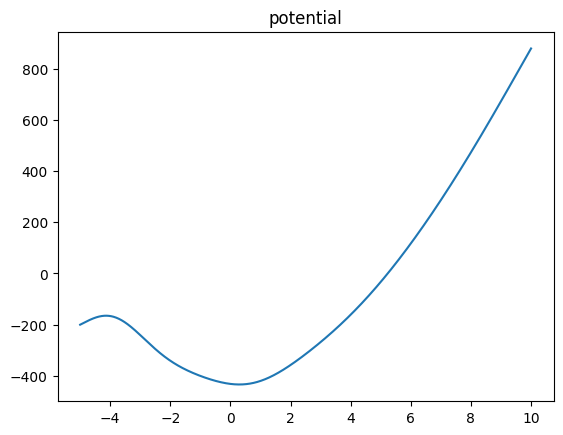

In [18]:
macro.Show_NoiseSigmoid(ansatz)

In [19]:
wcrg.save_ansatz(ansatz, L, KEY, dir_mod) 

## Macro-canonical denoising synthesis

First we denoise an image using micro-canonical baseline method. Then we use coarse-grained L = 16 image as a starting condition for generation of L = 32, 64, 128 images

In [252]:
wph_op = bayes.create_wph_operator(d[0])
d_coeffs = wph_op.apply(d[0], norm='auto')

loss_threshold = 10
y_list = []

for i in range(20):
    loss = loss_threshold
    while loss >= loss_threshold:    
        y, loss = bayes.denoise(wph_op, d_coeffs, np.random.randn(*d[0].shape), verbose=False)
    y_list.append(y)
    
y_list = np.stack(y_list)

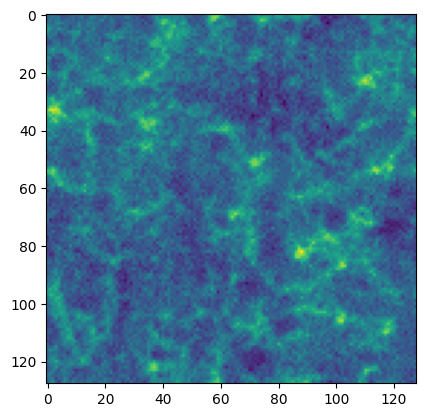

In [253]:
plt.imshow(y_list[0])
plt.show()

In [254]:
L = 16
x_16 = torch.tensor(y_list).cuda().float()
wcrg.save(x_16, L, KEY, dir_synth)

In [65]:
x_16 = torch.load('logs/synthesis/' + KEY + str(16) + '_synth.pt')

### L = 32

In [66]:
L = 32
J = int(np.log2(d.shape[-1]))

depth = J - int(np.log2(L))
ansatz = wcrg.load_ansatz(L, KEY, dir_mod)

n_batch = 20

phi_s = wcrg.load_data(W, s[:100], depth, J, show_hist=False)
x_reco = wcrg.load_data(W, x_16, depth+1, J, show_hist=False)
x_reco = W.Inv_2d(x_reco, torch.zeros_like(x_reco), torch.zeros_like(x_reco), torch.zeros_like(x_reco))

window_min, window_max = ansatz.ansatze[0].centers[0], ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_steps = 500 
step_size = 2.5e-1

x_32 = wcrg.LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat)

Acceptance_rate =0.050000000000000044
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.19999999999999996
Acceptance_rate =0.44999999999999996
Acceptance_rate =0.65
Acceptance_rate =0.6
Acceptance_rate =0.6
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.6
Acceptance_rate =0.7
Acceptance_rate =0.75
Acceptance_rate =0.75
Acceptance_rate =0.7
Acceptance_rate =0.55
Acceptance_rate =0.75
Acceptance_rate =0.5
Acceptance_rate =0.7
Acceptance_rate =0.75
Acceptance_rate =0.75
Acceptance_rate =0.65
Acceptance_rate =0.6
Acceptance_rate =0.75
Acceptance_rate =0.85
Acceptance_rate =0.5
Acceptance_rate =0.75
Acceptance_rate =0.85
Acceptance_rate =0.65
Acceptance_rate =0.9
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.75
Acceptance_rate =0.8
Acceptance_rate =0.75
Acceptance_rate =0.8
Acceptance_rate =0.7
Acceptance_rate =0.9
Acceptance_rate =0.7
Acceptance_rate =0.75
Acceptance_rate =0.7
Acceptance_rate =0.9
Acceptance_rate =0.75

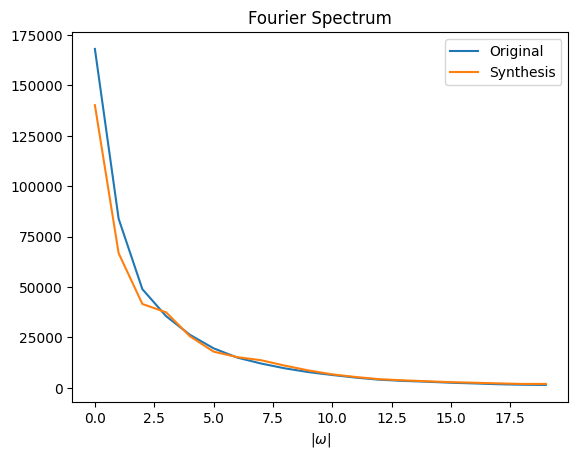

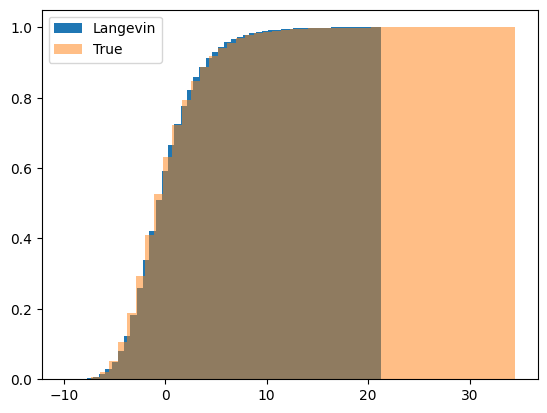

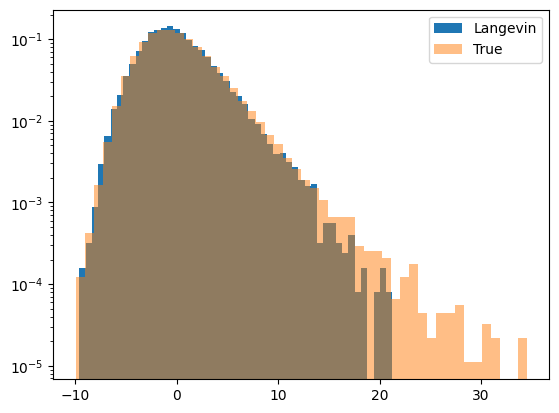

mean_true = tensor(0.1115)
std_true = tensor(3.5547)
mean_langevin = tensor(-0.0003)
std_langevin = tensor(3.3278)


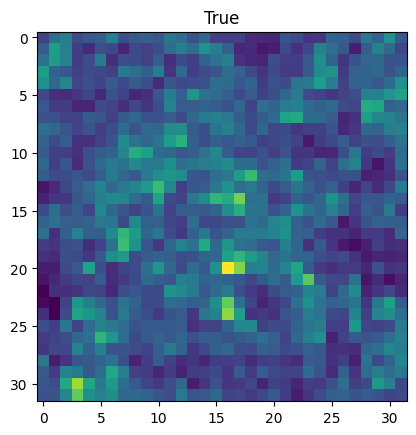

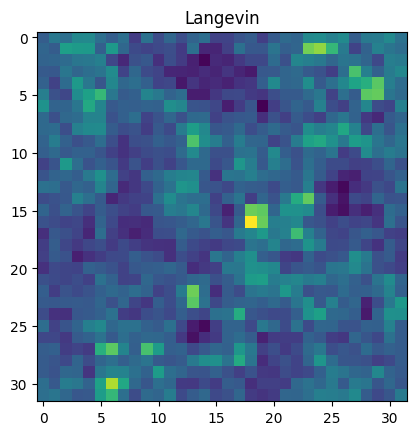

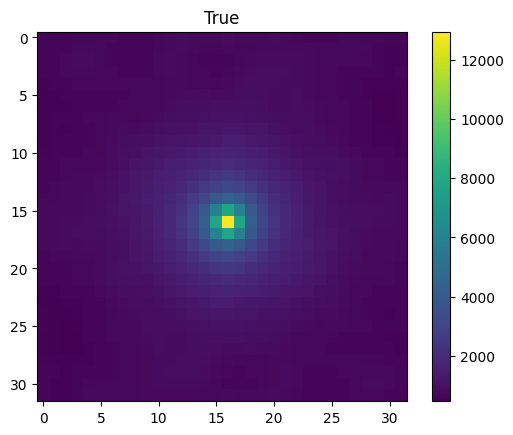

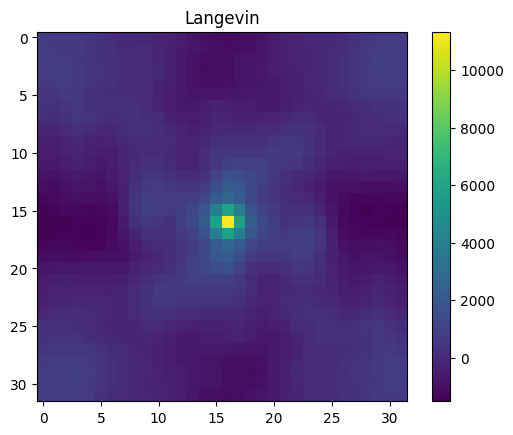

In [67]:
wcrg.Show_langevin(phi_s, x_32, log=True)

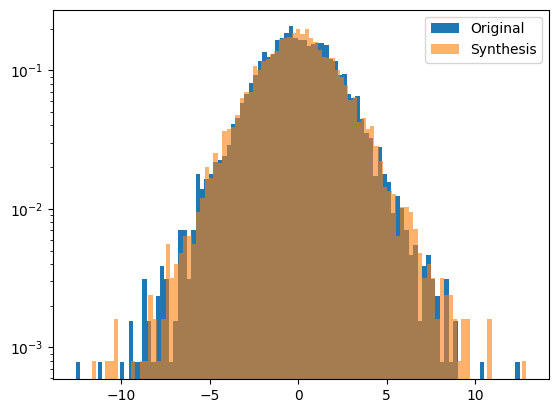

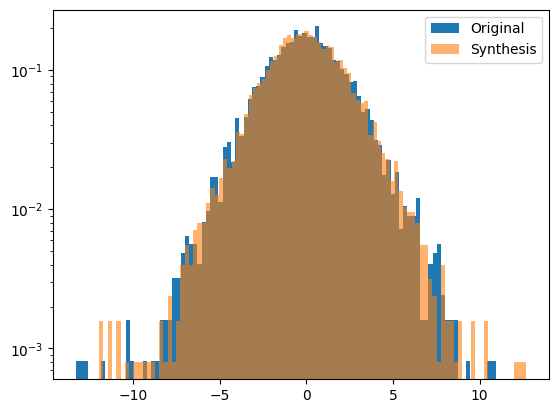

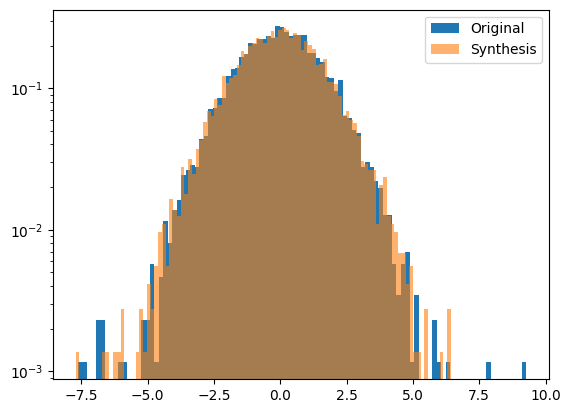

In [68]:
x_high_reco = ansatz.decompose(x_32.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_32)]
wcrg.compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
wcrg.compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
wcrg.compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [71]:
wcrg.save(x_32, L, KEY, dir_synth)

### L = 64

In [72]:
L = 64
J = int(np.log2(d.shape[-1]))

depth = J - int(np.log2(L))
ansatz = wcrg.load_ansatz(L, KEY, dir_mod)

n_batch = 20

phi_s = wcrg.load_data(W, s[:100], depth, J, show_hist=False)
x_reco = x_32.cuda()
x_reco = W.Inv_2d(x_reco, torch.zeros_like(x_reco), torch.zeros_like(x_reco), torch.zeros_like(x_reco))

window_min, window_max = ansatz.ansatze[0].centers[0], ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_steps = 250  
step_size = 1.5e-2

x_64 = wcrg.LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat)

Acceptance_rate =0.15000000000000002
Acceptance_rate =0.15000000000000002
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.5
Acceptance_rate =0.35
Acceptance_rate =0.5
Acceptance_rate =0.75
Acceptance_rate =0.65
Acceptance_rate =0.9
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.85
Acceptance_rate =0.95
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.85
Acceptance_rate =0.9
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.7
Acceptance_rate =1.0
Acceptance_rate =0.9
Acceptance_rate =0.75
Acceptance_rate =0.8
Acceptance_rate =0.9


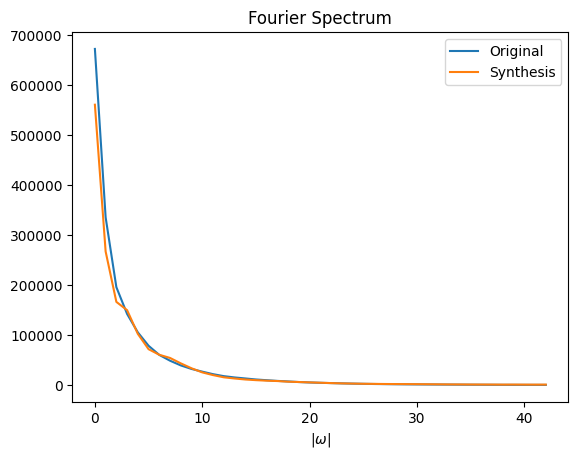

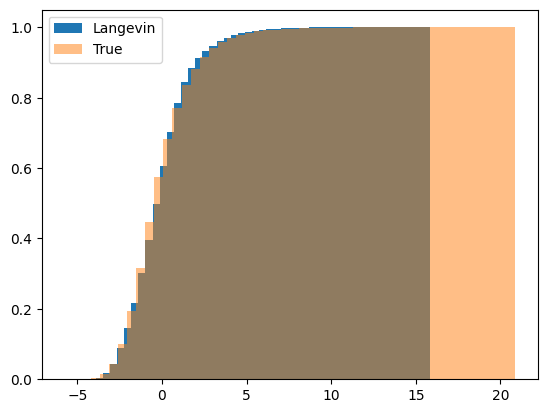

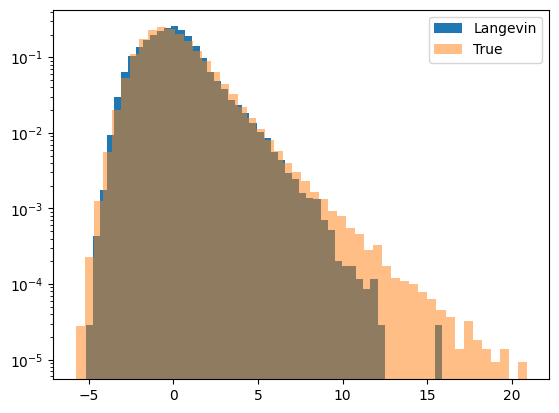

mean_true = tensor(0.0557)
std_true = tensor(1.9356)
mean_langevin = tensor(-0.0002)
std_langevin = tensor(1.8085)


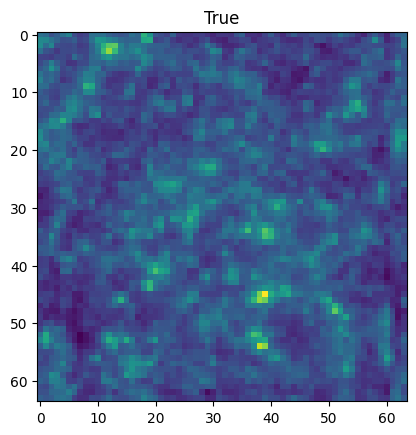

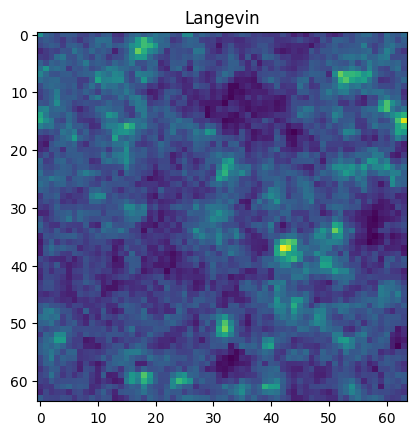

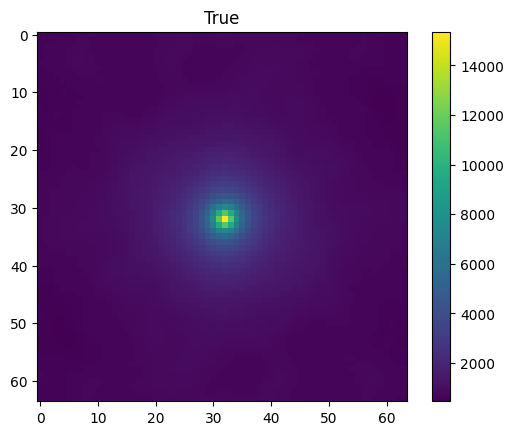

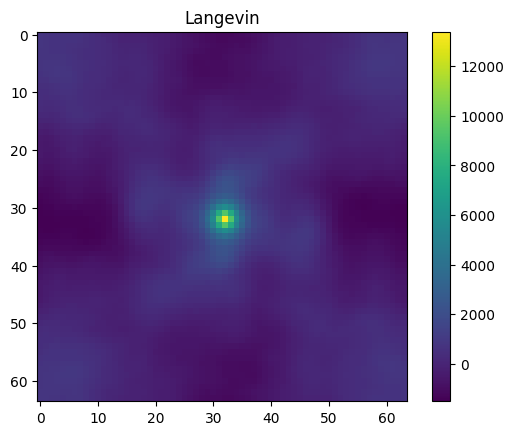

In [73]:
wcrg.Show_langevin(phi_s, x_64, log=True)

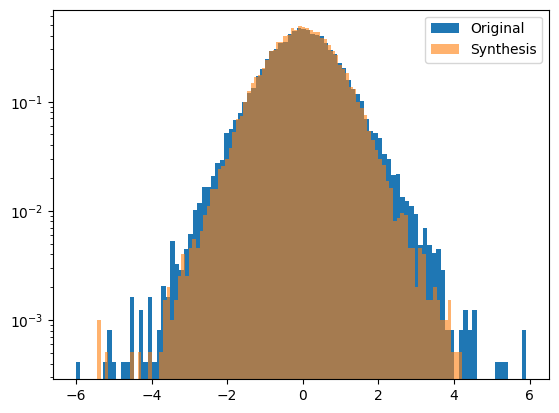

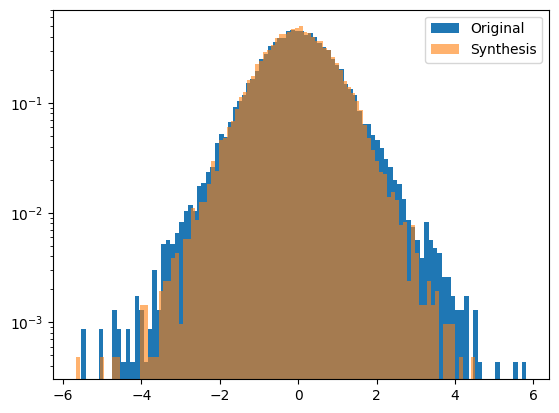

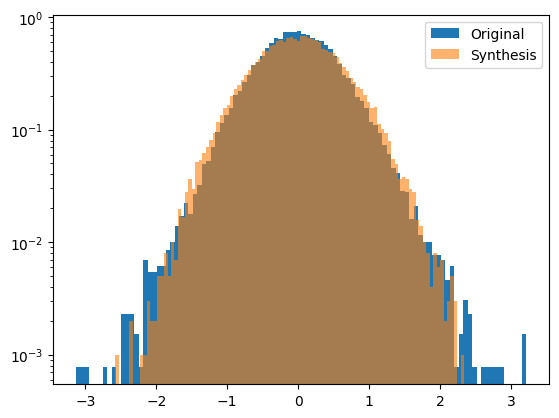

In [74]:
x_high_reco = ansatz.decompose(x_64.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_64)]
wcrg.compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
wcrg.compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
wcrg.compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [75]:
wcrg.save(x_64, L, KEY, dir_synth)

In [20]:
x_64 = torch.load('logs/synthesis/' + KEY + str(64) + '_synth.pt')

### L = 128

In [21]:
L = 128
J = int(np.log2(d.shape[-1]))

depth = J - int(np.log2(L))
ansatz = wcrg.load_ansatz(L, KEY, dir_mod)

phi_s = wcrg.load_data(W, s[:100], depth, J, show_hist=False)
x_reco = x_64.cuda()
x_reco = W.Inv_2d(x_reco, torch.zeros_like(x_reco), torch.zeros_like(x_reco), torch.zeros_like(x_reco))

window_min, window_max = ansatz.ansatze[0].centers[0], ansatz.ansatze[0].centers[-1]
n_repeat = 2
n_batch = 10
n_steps = 700
step_size = 5e-4

x_128 = wcrg.LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat)

Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.19999999999999996
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.4
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.4
Acceptance_rate =0.30000000000000004
Acceptance_rate =0.19999999999999996
Acceptance_rate =0.6
Acceptance_rate =0.8
Acceptance_rate =0.5
Acceptance_rate =0.5
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.9
Acceptance_rate =0.8
Acceptance_rate =0.6
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.6
Acceptance_rate =0.6
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =0.6
Acceptance_rate =0.9
Acceptance_rate =0.9
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_

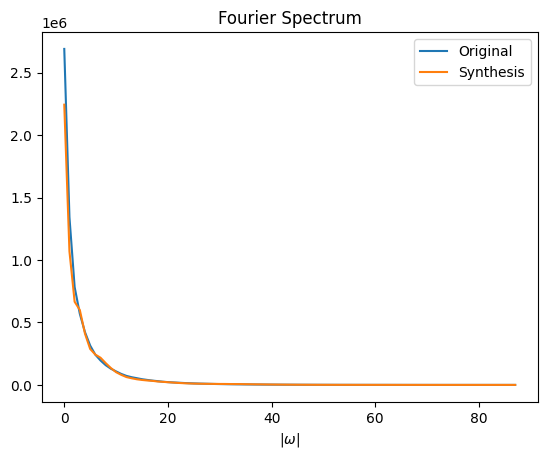

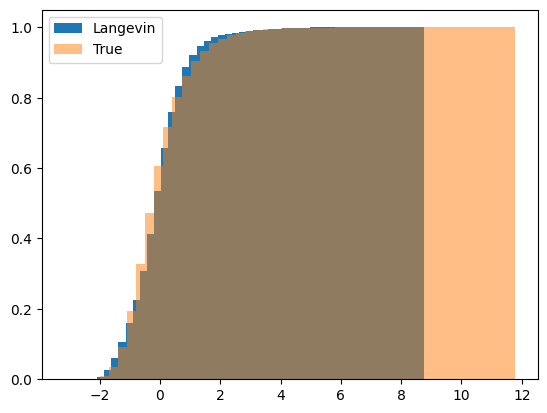

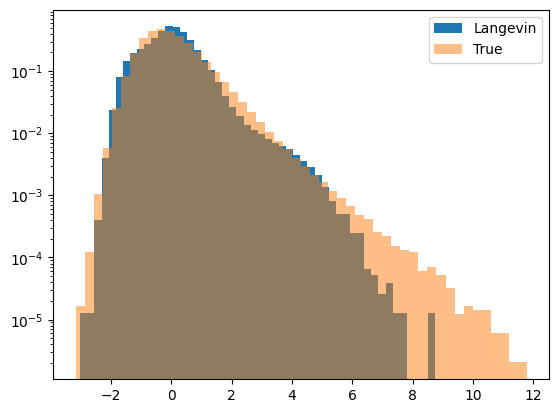

mean_true = tensor(0.0279)
std_true = tensor(0.9997)
mean_langevin = tensor(-8.4576e-05)
std_langevin = tensor(0.9381)


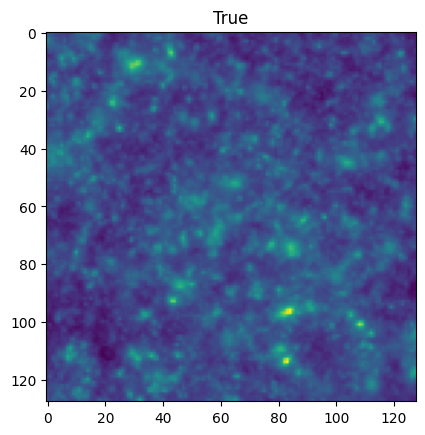

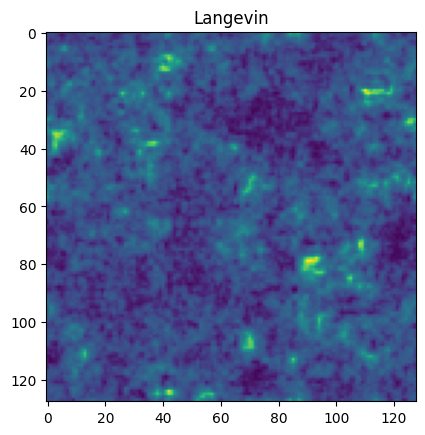

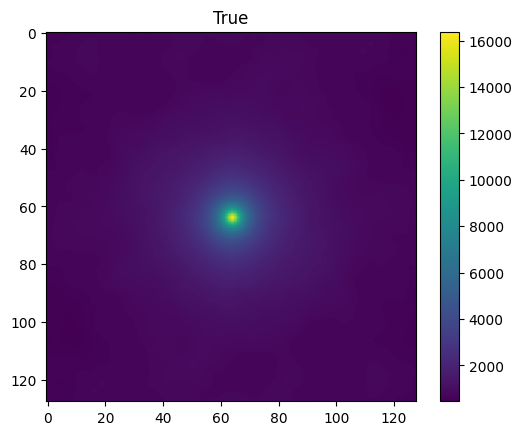

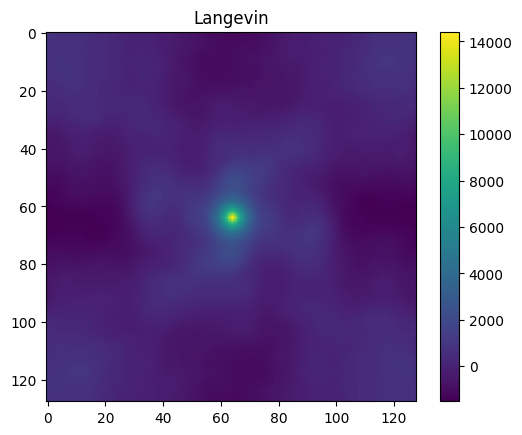

In [22]:
wcrg.Show_langevin(phi_s, x_128, log=True)

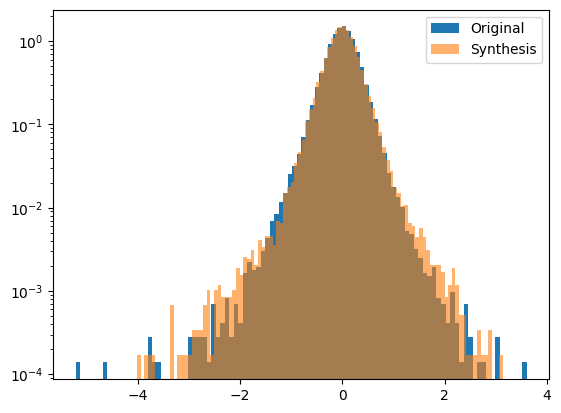

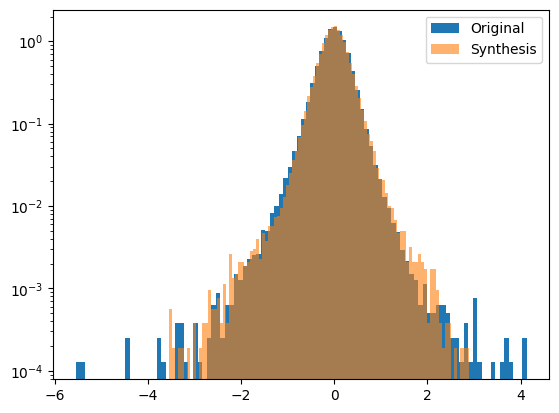

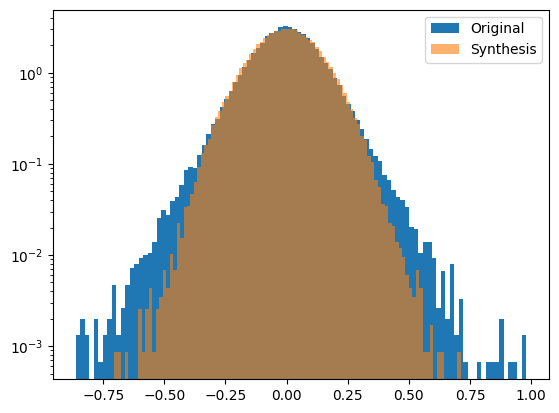

In [23]:
x_high_reco = ansatz.decompose(x_128.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_128)]
wcrg.compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
wcrg.compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
wcrg.compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [24]:
wcrg.save(x_128, L, KEY, dir_synth)

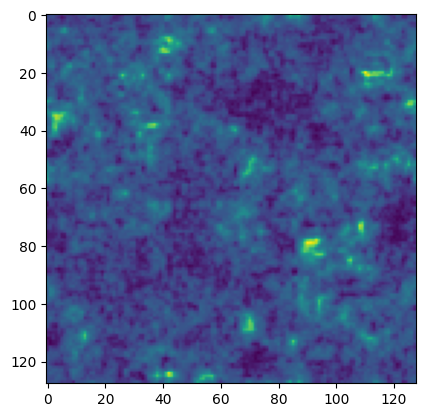

In [25]:
plt.imshow(x_128[0].cpu())
plt.show()

## Miyasawa denoising

For model $d = s + n$, where $n$ is white noise, we have $\hat{s}(d) = \mathbb{E}_{s\sim p(s|d)} s = d + \sigma^2\nabla_d\log p(d)$. We can learn $p(d)$ as a macro-canonical distribution and then easily calculate its gradient to perform this denoising. Further details and references can be found in the report.

In [4]:
KEY = '128_weak_lensing_miyasawa'
dir_mod = 'logs/ansatz/'
dir_synth = 'logs/synthesis/'

m = 4
W = wcrg.Db_wavelets(m, device='cuda', mode='Periodic')

In [23]:
x_16 = wcrg.load_data(W, torch.load('logs/synthesis/128_weak_lensing16_synth.pt'), 3, 7, show_hist=False)

### L = 32

In [7]:
J = int(np.log2(d.shape[-1]))
L = 32

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s.float(), depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d.float(), depth, J, show_hist=False)

In [8]:
mask = torch.bitwise_and(torch.max(phi_d.reshape(-1,(L*L)),1)[0]<25, torch.min(phi_d.reshape(-1,(L*L)),1)[0]>-10)
phi_d = phi_d[mask]
phi_s = phi_s[mask]
phi_d.shape, phi_s.shape

(torch.Size([4715, 32, 32]), torch.Size([4715, 32, 32]))

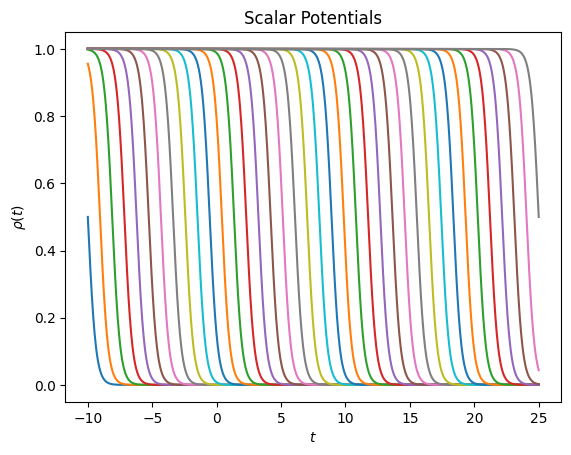

In [11]:
num_potentials = 38

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (0,2),(2,0),(2,2),(-2,2),
          (2,1),(1,2),(-1,2),(2,-1))

centers = torch.linspace(-10, 25, num_potentials).cuda()
sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

wcrg.Plot_Sigmoid(centers, sigma)

mode = 'All'
ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [12]:
dataloader = torch.utils.data.DataLoader(phi_d, batch_size=50)
wcrg.Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
wcrg.optim(ansatz,dataloader,num_epochs=50,lr=1e-3,momentum=0,weight_decay=0)

/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/

[0/50] loss: 0.0
[0/50] loss: -1.2849222
[0/50] loss: -2.5793288
[0/50] loss: -3.7635174
[0/50] loss: -5.0893574
[0/50] loss: -6.1539779
[0/50] loss: -7.4783845
[0/50] loss: -8.777668
[0/50] loss: -9.9838839
[0/50] loss: -11.060115
[0/50] loss: -12.713688
[0/50] loss: -13.624416
[0/50] loss: -15.326609
[0/50] loss: -16.02503
[0/50] loss: -17.631557
[0/50] loss: -18.97435
[0/50] loss: -19.234747
[0/50] loss: -20.424299
[0/50] loss: -21.854113
[0/50] loss: -23.535646
[0/50] loss: -25.248613
[0/50] loss: -25.51034
[0/50] loss: -26.550785
[0/50] loss: -27.71454
[0/50] loss: -29.071783
[0/50] loss: -29.484406
[0/50] loss: -30.49527
[0/50] loss: -31.40933
[0/50] loss: -33.260223
[0/50] loss: -34.851032
[0/50] loss: -35.941067
[0/50] loss: -36.987041
[0/50] loss: -35.793289
[0/50] loss: -37.95385
[0/50] loss: -39.292786
[0/50] loss: -40.297176
[0/50] loss: -41.632942
[0/50] loss: -43.122723
[0/50] loss: -43.624645
[0/50] loss: -43.883789
[0/50] loss: -46.188316
[0/50] loss: -45.872387
[0/50] 

[3/50] loss: -166.17554
[3/50] loss: -160.66698
[3/50] loss: -161.66614
[3/50] loss: -164.81268
[3/50] loss: -165.7229
[3/50] loss: -168.53453
[3/50] loss: -167.87415
[3/50] loss: -162.58081
[3/50] loss: -163.46368
[3/50] loss: -167.67349
[3/50] loss: -167.01714
[3/50] loss: -165.59079
[3/50] loss: -166.38162
[3/50] loss: -166.23303
[3/50] loss: -165.30496
[3/50] loss: -163.59793
[3/50] loss: -170.41473
[3/50] loss: -164.5788
[3/50] loss: -158.32248
[3/50] loss: -167.73878
[3/50] loss: -166.23126
[3/50] loss: -167.26785
[3/50] loss: -170.31673
[3/50] loss: -169.06506
[3/50] loss: -169.78859
[3/50] loss: -165.32822
[3/50] loss: -170.67255
[3/50] loss: -166.78461
[3/50] loss: -169.23669
[3/50] loss: -172.11505
[3/50] loss: -169.25549
[3/50] loss: -167.84326
[3/50] loss: -167.19101
[3/50] loss: -172.50153
[3/50] loss: -170.15009
[3/50] loss: -165.37718
[4/50] loss: -165.40524
[4/50] loss: -167.54855
[4/50] loss: -167.25581
[4/50] loss: -167.56915
[4/50] loss: -168.79503
[4/50] loss: -164.

[7/50] loss: -186.7715
[7/50] loss: -177.9653
[7/50] loss: -185.20909
[7/50] loss: -181.03209
[7/50] loss: -181.63072
[7/50] loss: -187.35196
[7/50] loss: -183.30234
[7/50] loss: -182.6427
[7/50] loss: -180.57553
[7/50] loss: -180.81764
[7/50] loss: -180.86987
[7/50] loss: -181.15144
[7/50] loss: -184.92625
[7/50] loss: -187.07332
[7/50] loss: -184.58479
[7/50] loss: -181.29509
[7/50] loss: -186.00443
[7/50] loss: -182.76309
[7/50] loss: -182.98326
[7/50] loss: -185.58685
[7/50] loss: -183.22478
[7/50] loss: -184.75616
[7/50] loss: -184.22993
[7/50] loss: -187.5209
[7/50] loss: -184.92827
[7/50] loss: -191.64644
[7/50] loss: -183.23438
[7/50] loss: -184.3903
[7/50] loss: -186.40132
[7/50] loss: -182.84532
[7/50] loss: -184.64337
[7/50] loss: -181.32185
[7/50] loss: -185.65024
[7/50] loss: -184.1468
[7/50] loss: -185.12714
[7/50] loss: -178.07663
[7/50] loss: -185.34241
[7/50] loss: -182.62213
[7/50] loss: -181.84921
[7/50] loss: -182.28033
[7/50] loss: -186.84143
[7/50] loss: -183.9107

[10/50] loss: -184.28355
[10/50] loss: -188.79973
[10/50] loss: -192.68294
[10/50] loss: -188.84039
[10/50] loss: -192.67662
[10/50] loss: -185.51035
[10/50] loss: -180.95262
[10/50] loss: -192.96448
[10/50] loss: -187.18704
[10/50] loss: -184.84424
[10/50] loss: -191.71497
[10/50] loss: -190.17351
[10/50] loss: -193.01758
[10/50] loss: -185.80957
[10/50] loss: -190.80582
[10/50] loss: -188.87065
[10/50] loss: -183.30347
[11/50] loss: -190.07068
[11/50] loss: -185.42323
[11/50] loss: -185.58817
[11/50] loss: -185.39081
[11/50] loss: -191.00877
[11/50] loss: -183.91365
[11/50] loss: -183.44341
[11/50] loss: -187.965
[11/50] loss: -186.92101
[11/50] loss: -186.98453
[11/50] loss: -193.17535
[11/50] loss: -192.3134
[11/50] loss: -194.70224
[11/50] loss: -188.11143
[11/50] loss: -191.74609
[11/50] loss: -186.56758
[11/50] loss: -183.72932
[11/50] loss: -186.41057
[11/50] loss: -187.02077
[11/50] loss: -191.64984
[11/50] loss: -191.0764
[11/50] loss: -185.32416
[11/50] loss: -197.43614
[11/

[14/50] loss: -182.96074
[14/50] loss: -190.86977
[14/50] loss: -188.33829
[14/50] loss: -184.42245
[14/50] loss: -185.56345
[14/50] loss: -189.91814
[14/50] loss: -192.60216
[14/50] loss: -193.69246
[14/50] loss: -189.39508
[14/50] loss: -191.66676
[14/50] loss: -186.8024
[14/50] loss: -189.73813
[14/50] loss: -190.71773
[14/50] loss: -186.76025
[14/50] loss: -187.12517
[14/50] loss: -190.26059
[14/50] loss: -193.08607
[14/50] loss: -188.29059
[14/50] loss: -195.32164
[14/50] loss: -188.27676
[14/50] loss: -187.42299
[14/50] loss: -188.81276
[14/50] loss: -181.95537
[14/50] loss: -187.97459
[14/50] loss: -185.92998
[14/50] loss: -189.92287
[14/50] loss: -188.21844
[14/50] loss: -193.93314
[14/50] loss: -180.63785
[14/50] loss: -191.11281
[14/50] loss: -187.23378
[14/50] loss: -180.80966
[14/50] loss: -189.31543
[14/50] loss: -190.36739
[14/50] loss: -186.35283
[14/50] loss: -191.4805
[14/50] loss: -184.9915
[14/50] loss: -188.84534
[14/50] loss: -189.68092
[14/50] loss: -184.95644
[14

[17/50] loss: -184.02794
[17/50] loss: -188.99037
[17/50] loss: -187.24374
[17/50] loss: -190.34822
[17/50] loss: -187.571
[17/50] loss: -193.6882
[17/50] loss: -188.16109
[17/50] loss: -179.68398
[17/50] loss: -187.66805
[17/50] loss: -189.90436
[17/50] loss: -189.34628
[17/50] loss: -193.61348
[17/50] loss: -194.74236
[17/50] loss: -190.60767
[17/50] loss: -189.70215
[17/50] loss: -192.99548
[17/50] loss: -186.65843
[17/50] loss: -182.19327
[18/50] loss: -186.78358
[18/50] loss: -187.2261
[18/50] loss: -187.30879
[18/50] loss: -187.27591
[18/50] loss: -195.76305
[18/50] loss: -185.32646
[18/50] loss: -184.06618
[18/50] loss: -188.99203
[18/50] loss: -190.19562
[18/50] loss: -189.48174
[18/50] loss: -195.83928
[18/50] loss: -193.22488
[18/50] loss: -194.65749
[18/50] loss: -192.36807
[18/50] loss: -192.43318
[18/50] loss: -182.30403
[18/50] loss: -188.53189
[18/50] loss: -189.90721
[18/50] loss: -187.81046
[18/50] loss: -193.47475
[18/50] loss: -192.22823
[18/50] loss: -187.6691
[18/5

[21/50] loss: -190.26126
[21/50] loss: -185.96341
[21/50] loss: -186.0215
[21/50] loss: -188.06384
[21/50] loss: -184.30229
[21/50] loss: -190.50444
[21/50] loss: -189.13548
[21/50] loss: -194.93631
[21/50] loss: -190.34456
[21/50] loss: -189.66666
[21/50] loss: -191.7534
[21/50] loss: -188.86092
[21/50] loss: -187.16997
[21/50] loss: -192.95149
[21/50] loss: -188.05528
[21/50] loss: -186.0947
[21/50] loss: -190.89047
[21/50] loss: -192.4767
[21/50] loss: -186.28679
[21/50] loss: -191.901
[21/50] loss: -189.69868
[21/50] loss: -194.0746
[21/50] loss: -193.99286
[21/50] loss: -186.71909
[21/50] loss: -190.90292
[21/50] loss: -192.08615
[21/50] loss: -184.78017
[21/50] loss: -191.44438
[21/50] loss: -192.74391
[21/50] loss: -184.70816
[21/50] loss: -188.05585
[21/50] loss: -186.69487
[21/50] loss: -182.77887
[21/50] loss: -187.97626
[21/50] loss: -194.24164
[21/50] loss: -189.52847
[21/50] loss: -190.653
[21/50] loss: -189.1962
[21/50] loss: -191.05139
[21/50] loss: -188.96051
[21/50] lo

[24/50] loss: -188.97214
[24/50] loss: -182.1628
[24/50] loss: -191.37099
[24/50] loss: -188.10387
[24/50] loss: -193.57274
[24/50] loss: -191.29706
[24/50] loss: -192.43445
[24/50] loss: -190.18111
[24/50] loss: -186.26871
[24/50] loss: -189.2821
[24/50] loss: -190.73964
[24/50] loss: -187.17583
[24/50] loss: -192.22128
[24/50] loss: -192.80359
[24/50] loss: -190.90845
[24/50] loss: -187.70352
[24/50] loss: -199.68102
[24/50] loss: -191.03302
[24/50] loss: -186.89615
[25/50] loss: -188.25084
[25/50] loss: -185.82893
[25/50] loss: -186.33171
[25/50] loss: -189.70537
[25/50] loss: -188.53009
[25/50] loss: -187.27058
[25/50] loss: -187.51645
[25/50] loss: -184.82494
[25/50] loss: -187.64375
[25/50] loss: -187.16008
[25/50] loss: -196.33844
[25/50] loss: -191.83498
[25/50] loss: -193.77538
[25/50] loss: -191.07628
[25/50] loss: -193.73872
[25/50] loss: -184.24657
[25/50] loss: -186.74399
[25/50] loss: -189.23288
[25/50] loss: -184.2496
[25/50] loss: -191.92339
[25/50] loss: -189.75113
[25

[28/50] loss: -195.08145
[28/50] loss: -194.3566
[28/50] loss: -186.34428
[28/50] loss: -185.18874
[28/50] loss: -191.70387
[28/50] loss: -183.05959
[28/50] loss: -186.6172
[28/50] loss: -191.00897
[28/50] loss: -192.3605
[28/50] loss: -189.42577
[28/50] loss: -186.92152
[28/50] loss: -191.9493
[28/50] loss: -190.35428
[28/50] loss: -186.26494
[28/50] loss: -190.20589
[28/50] loss: -188.02361
[28/50] loss: -185.44675
[28/50] loss: -191.3264
[28/50] loss: -191.70454
[28/50] loss: -188.42444
[28/50] loss: -195.14247
[28/50] loss: -189.39189
[28/50] loss: -195.60335
[28/50] loss: -188.12285
[28/50] loss: -185.0076
[28/50] loss: -187.47041
[28/50] loss: -189.55934
[28/50] loss: -187.80579
[28/50] loss: -189.86823
[28/50] loss: -194.38051
[28/50] loss: -183.23586
[28/50] loss: -192.57448
[28/50] loss: -192.75691
[28/50] loss: -182.76958
[28/50] loss: -188.20126
[28/50] loss: -191.646
[28/50] loss: -190.45294
[28/50] loss: -187.84595
[28/50] loss: -187.52785
[28/50] loss: -187.8084
[28/50] l

[31/50] loss: -191.20717
[31/50] loss: -184.82013
[31/50] loss: -184.16765
[31/50] loss: -190.4003
[31/50] loss: -187.04265
[31/50] loss: -194.85547
[31/50] loss: -193.56963
[31/50] loss: -195.38391
[31/50] loss: -186.49773
[31/50] loss: -187.38632
[31/50] loss: -192.45998
[31/50] loss: -191.26979
[31/50] loss: -187.22658
[31/50] loss: -191.77177
[31/50] loss: -194.0862
[31/50] loss: -191.14334
[31/50] loss: -187.97318
[31/50] loss: -191.99251
[31/50] loss: -188.05959
[31/50] loss: -191.46338
[32/50] loss: -193.58052
[32/50] loss: -187.57535
[32/50] loss: -186.60272
[32/50] loss: -189.06326
[32/50] loss: -188.57841
[32/50] loss: -190.25589
[32/50] loss: -184.77649
[32/50] loss: -182.30038
[32/50] loss: -190.08867
[32/50] loss: -187.91486
[32/50] loss: -200.73586
[32/50] loss: -196.99338
[32/50] loss: -194.52675
[32/50] loss: -187.10269
[32/50] loss: -195.56238
[32/50] loss: -186.91956
[32/50] loss: -186.13132
[32/50] loss: -186.18269
[32/50] loss: -188.30058
[32/50] loss: -193.84546
[3

[35/50] loss: -193.10666
[35/50] loss: -191.23296
[35/50] loss: -189.16339
[35/50] loss: -189.76309
[35/50] loss: -188.00549
[35/50] loss: -187.04308
[35/50] loss: -185.95213
[35/50] loss: -185.52791
[35/50] loss: -190.80067
[35/50] loss: -190.8524
[35/50] loss: -194.05972
[35/50] loss: -190.22737
[35/50] loss: -198.21176
[35/50] loss: -188.87878
[35/50] loss: -187.24026
[35/50] loss: -191.65375
[35/50] loss: -186.38472
[35/50] loss: -186.46587
[35/50] loss: -189.61758
[35/50] loss: -191.52373
[35/50] loss: -189.70924
[35/50] loss: -194.1783
[35/50] loss: -189.44855
[35/50] loss: -190.05347
[35/50] loss: -192.21989
[35/50] loss: -188.02647
[35/50] loss: -190.73943
[35/50] loss: -188.60669
[35/50] loss: -187.15465
[35/50] loss: -189.29381
[35/50] loss: -189.49841
[35/50] loss: -187.15775
[35/50] loss: -192.43727
[35/50] loss: -189.41718
[35/50] loss: -186.95039
[35/50] loss: -188.22641
[35/50] loss: -188.67841
[35/50] loss: -187.09541
[35/50] loss: -188.3004
[35/50] loss: -187.73097
[35

[38/50] loss: -188.15332
[38/50] loss: -193.4771
[38/50] loss: -187.79869
[38/50] loss: -184.26337
[38/50] loss: -187.12598
[38/50] loss: -187.45995
[38/50] loss: -195.62308
[38/50] loss: -193.43181
[38/50] loss: -195.30859
[38/50] loss: -189.32535
[38/50] loss: -184.54413
[38/50] loss: -193.93835
[38/50] loss: -189.11765
[38/50] loss: -186.90909
[38/50] loss: -194.33087
[38/50] loss: -191.89311
[38/50] loss: -192.9762
[38/50] loss: -190.81744
[38/50] loss: -191.57918
[38/50] loss: -188.1759
[38/50] loss: -189.31642
[39/50] loss: -192.14633
[39/50] loss: -184.10156
[39/50] loss: -189.06149
[39/50] loss: -191.82431
[39/50] loss: -191.25687
[39/50] loss: -190.32773
[39/50] loss: -186.12189
[39/50] loss: -185.93927
[39/50] loss: -188.43581
[39/50] loss: -189.34706
[39/50] loss: -195.60161
[39/50] loss: -196.28535
[39/50] loss: -194.2139
[39/50] loss: -188.86632
[39/50] loss: -193.41127
[39/50] loss: -185.01321
[39/50] loss: -185.27596
[39/50] loss: -184.92592
[39/50] loss: -187.74548
[39/

[42/50] loss: -191.34369
[42/50] loss: -186.52232
[42/50] loss: -193.92564
[42/50] loss: -189.07729
[42/50] loss: -188.84918
[42/50] loss: -188.00656
[42/50] loss: -185.27777
[42/50] loss: -183.16875
[42/50] loss: -189.5806
[42/50] loss: -191.34561
[42/50] loss: -195.0623
[42/50] loss: -193.97049
[42/50] loss: -187.79982
[42/50] loss: -195.97589
[42/50] loss: -193.3557
[42/50] loss: -188.42543
[42/50] loss: -188.12688
[42/50] loss: -184.57875
[42/50] loss: -186.69737
[42/50] loss: -192.65771
[42/50] loss: -192.84665
[42/50] loss: -188.93672
[42/50] loss: -193.51895
[42/50] loss: -189.27184
[42/50] loss: -191.00186
[42/50] loss: -192.94562
[42/50] loss: -187.67136
[42/50] loss: -185.9537
[42/50] loss: -190.6852
[42/50] loss: -189.00792
[42/50] loss: -190.09598
[42/50] loss: -187.65875
[42/50] loss: -184.31038
[42/50] loss: -189.25681
[42/50] loss: -191.04095
[42/50] loss: -188.87514
[42/50] loss: -186.40479
[42/50] loss: -195.00737
[42/50] loss: -194.75035
[42/50] loss: -189.78568
[42/5

[45/50] loss: -186.19887
[45/50] loss: -187.75853
[45/50] loss: -192.74484
[45/50] loss: -190.00211
[45/50] loss: -184.4948
[45/50] loss: -188.44702
[45/50] loss: -189.04884
[45/50] loss: -192.65691
[45/50] loss: -191.44534
[45/50] loss: -193.88585
[45/50] loss: -189.70435
[45/50] loss: -181.69208
[45/50] loss: -191.37546
[45/50] loss: -188.9463
[45/50] loss: -186.62691
[45/50] loss: -193.45117
[45/50] loss: -190.57185
[45/50] loss: -191.04884
[45/50] loss: -187.67816
[45/50] loss: -192.3409
[45/50] loss: -190.49803
[45/50] loss: -189.68623
[46/50] loss: -192.92758
[46/50] loss: -188.80264
[46/50] loss: -188.81912
[46/50] loss: -187.2247
[46/50] loss: -195.3712
[46/50] loss: -190.7812
[46/50] loss: -189.87625
[46/50] loss: -189.50818
[46/50] loss: -190.95615
[46/50] loss: -190.77586
[46/50] loss: -196.26326
[46/50] loss: -195.00357
[46/50] loss: -197.58409
[46/50] loss: -185.93307
[46/50] loss: -195.45872
[46/50] loss: -185.08725
[46/50] loss: -185.27147
[46/50] loss: -187.3317
[46/50]

[49/50] loss: -191.70035
[49/50] loss: -192.6698
[49/50] loss: -191.53462
[49/50] loss: -190.48331
[49/50] loss: -191.39339
[49/50] loss: -188.40964
[49/50] loss: -186.48692
[49/50] loss: -190.25531
[49/50] loss: -181.59392
[49/50] loss: -186.7963
[49/50] loss: -193.48466
[49/50] loss: -192.58362
[49/50] loss: -192.25162
[49/50] loss: -191.0728
[49/50] loss: -193.26418
[49/50] loss: -186.40782
[49/50] loss: -183.47745
[49/50] loss: -190.02383
[49/50] loss: -187.6218
[49/50] loss: -185.80663
[49/50] loss: -187.25407
[49/50] loss: -194.75285
[49/50] loss: -187.83595
[49/50] loss: -194.00053
[49/50] loss: -189.51755
[49/50] loss: -191.79607
[49/50] loss: -192.6635
[49/50] loss: -188.04218
[49/50] loss: -189.05765
[49/50] loss: -190.827
[49/50] loss: -187.30019
[49/50] loss: -190.65706
[49/50] loss: -189.29512
[49/50] loss: -185.48083
[49/50] loss: -195.21524
[49/50] loss: -188.60234
[49/50] loss: -189.4207
[49/50] loss: -189.26407
[49/50] loss: -194.21272
[49/50] loss: -192.00584
[49/50] 

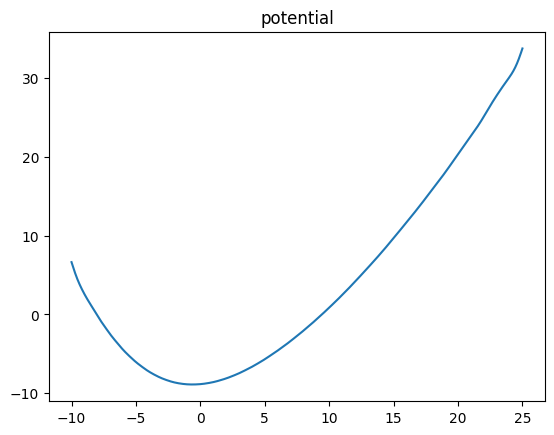

In [13]:
wcrg.Show_Sigmoid(ansatz)

In [14]:
wcrg.save_ansatz(ansatz,L,KEY,dir_mod)

In [25]:
d_condi, d_hf = ansatz.decompose(phi_d[:20])
s_hf = d_hf - ansatz.gradient(d_hf, d_condi, ansatz.theta().detach())[:, 0]
x_32 = ansatz.reconstruct(x_16, s_hf)

In [26]:
wcrg.save(x_32,L,KEY,dir_synth)

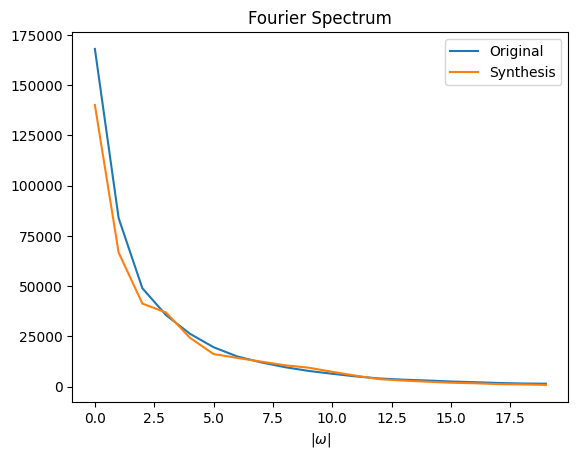

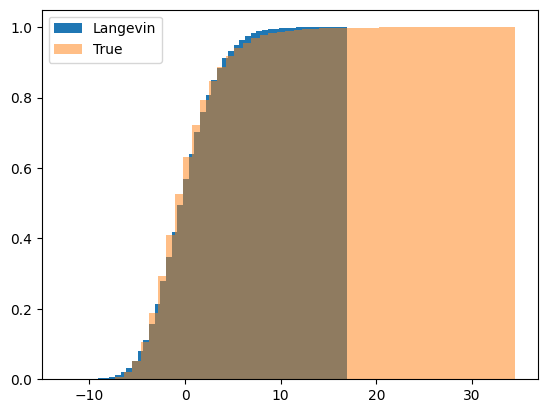

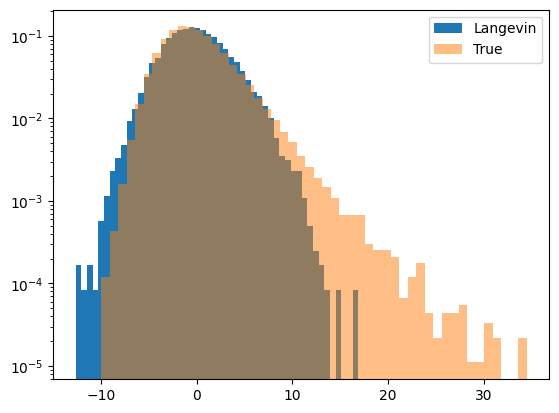

mean_true = tensor(0.1115)
std_true = tensor(3.5547)
mean_langevin = tensor(-0.0003)
std_langevin = tensor(3.2453)


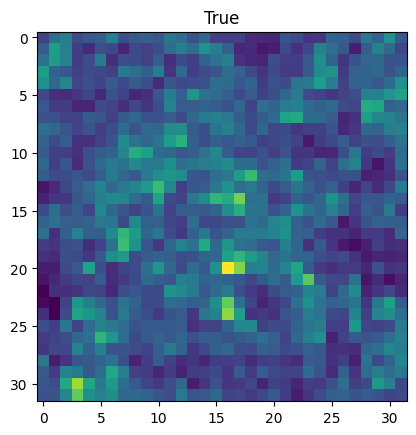

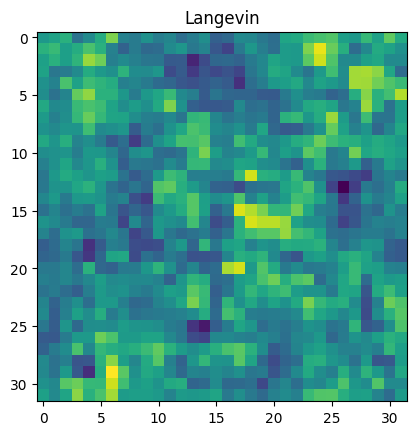

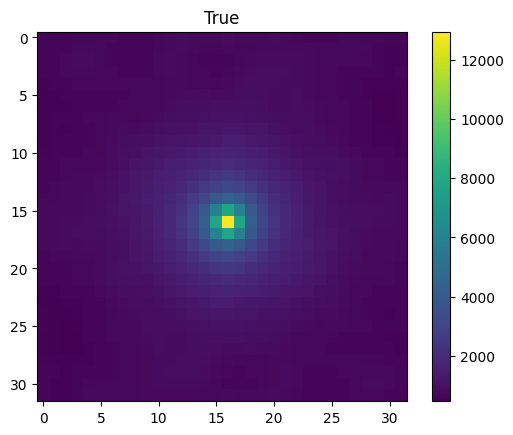

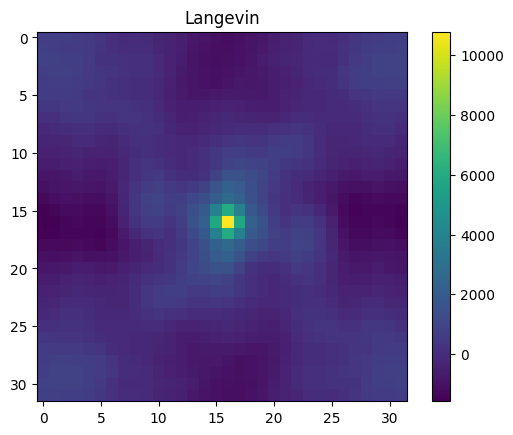

In [27]:
phi_s = wcrg.load_data(W, s[:100], depth, J, show_hist=False)
wcrg.Show_langevin(phi_s, x_32, log=True)

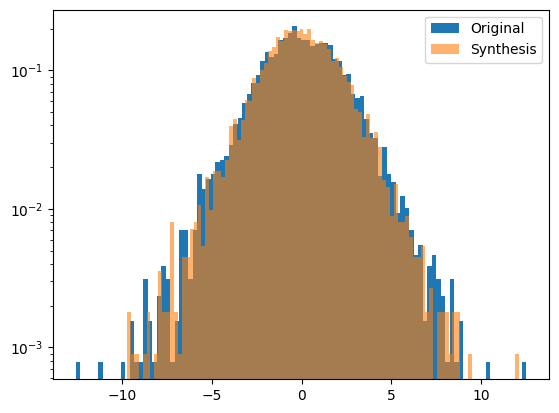

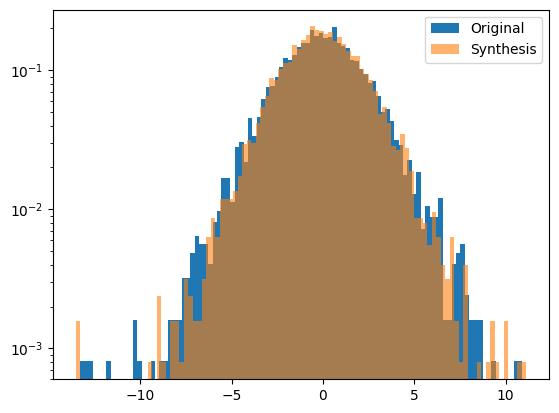

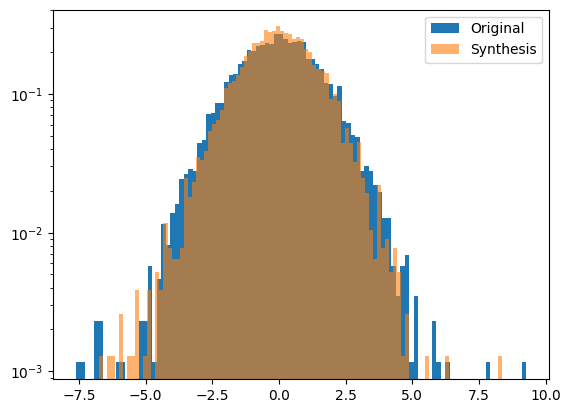

In [28]:
x_high_reco = ansatz.decompose(x_32.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_32)]
wcrg.compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
wcrg.compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
wcrg.compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

### L = 64

In [29]:
J = int(np.log2(d.shape[-1]))
L = 64

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s.float(), depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d.float(), depth, J, show_hist=False)

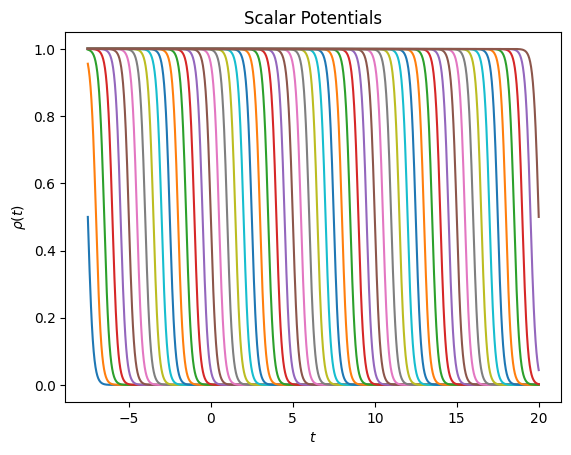

In [30]:
num_potentials = 56

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (2,0),(0,2),(2,2),(2,-2))

centers = torch.linspace(-7.5, 20, num_potentials).cuda()
sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

wcrg.Plot_Sigmoid(centers, sigma)

mode = 'All'
ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [31]:
dataloader = torch.utils.data.DataLoader(phi_d[:1000], batch_size=50)
wcrg.Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
wcrg.optim(ansatz,dataloader,num_epochs=2,lr=1e-2,momentum=0,weight_decay=0)
wcrg.optim(ansatz,dataloader,num_epochs=2,lr=1e-3,momentum=0,weight_decay=0)

[0/2] loss: 0.0
[0/2] loss: -138.88004
[0/2] loss: -271.90253
[0/2] loss: -386.89267
[0/2] loss: -495.03094
[0/2] loss: -604.52319
[0/2] loss: -692.70001
[0/2] loss: -780.5777
[0/2] loss: -869.47168
[0/2] loss: -946.28998
[0/2] loss: -1002.7687
[0/2] loss: -1079.2468
[0/2] loss: -1150.0657
[0/2] loss: -1219.6899
[0/2] loss: -1280.3186
[0/2] loss: -1280.0969
[0/2] loss: -1352.4225
[0/2] loss: -1403.823
[0/2] loss: -1445.51
[0/2] loss: -1473.4855
[1/2] loss: -1473.8372
[1/2] loss: -1546.7217
[1/2] loss: -1564.8977
[1/2] loss: -1571.7922
[1/2] loss: -1588.865
[1/2] loss: -1640.0627
[1/2] loss: -1636.6802
[1/2] loss: -1650.812
[1/2] loss: -1676.4998
[1/2] loss: -1722.5432
[1/2] loss: -1728.6868
[1/2] loss: -1734.1956
[1/2] loss: -1755.8903
[1/2] loss: -1806.208
[1/2] loss: -1805.6152
[1/2] loss: -1775.5715
[1/2] loss: -1818.3024
[1/2] loss: -1840.5574
[1/2] loss: -1821.6328
[1/2] loss: -1834.8435
[0/2] loss: -1822.9895
[0/2] loss: -1858.3018
[0/2] loss: -1844.7137
[0/2] loss: -1841.0166
[0

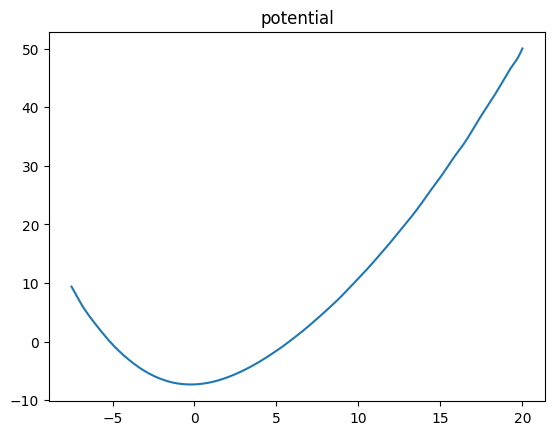

In [32]:
wcrg.Show_Sigmoid(ansatz)

In [33]:
wcrg.save_ansatz(ansatz,L,KEY,dir_mod)

In [34]:
d_condi, d_hf = ansatz.decompose(phi_d[:20])
s_hf = d_hf - ansatz.gradient(d_hf, d_condi, ansatz.theta().detach())[:, 0]
x_64 = ansatz.reconstruct(x_32, s_hf)

In [35]:
wcrg.save(x_64,L,KEY,dir_synth)

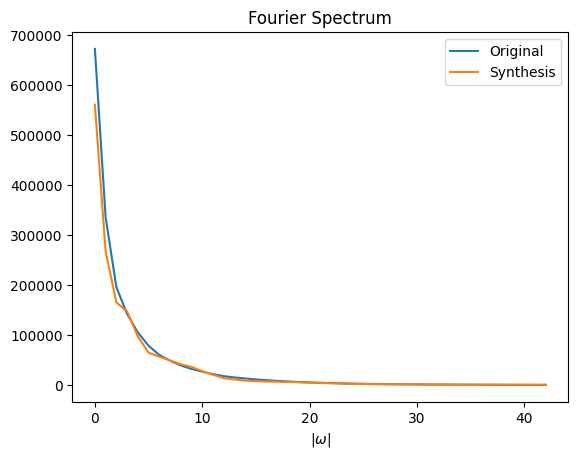

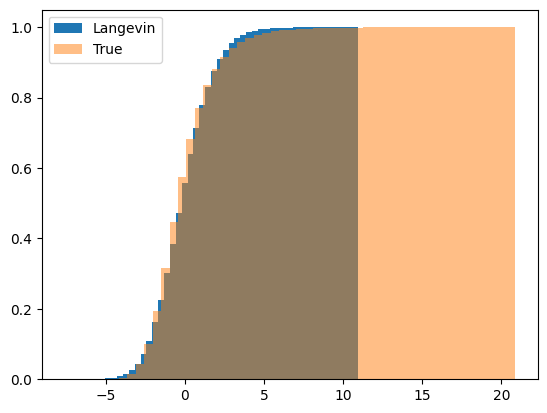

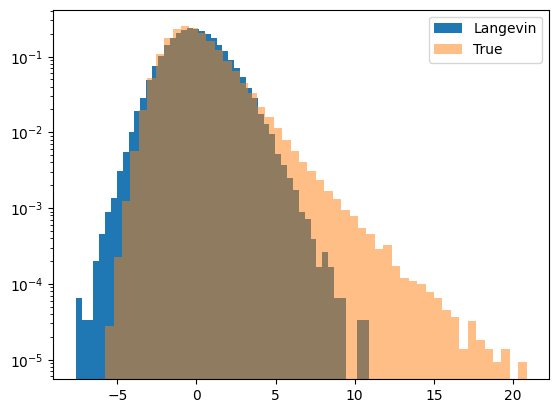

mean_true = tensor(0.0557)
std_true = tensor(1.9356)
mean_langevin = tensor(-0.0002)
std_langevin = tensor(1.7568)


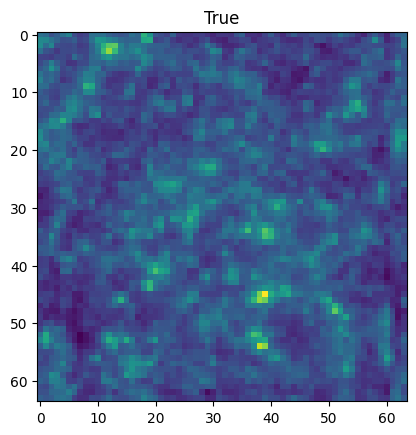

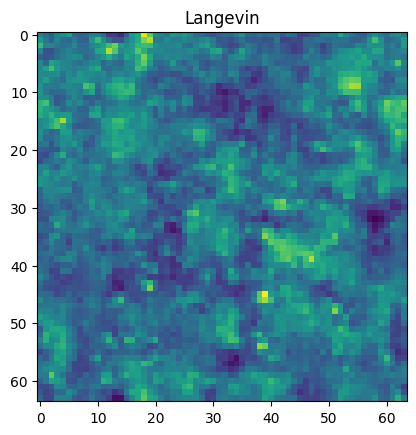

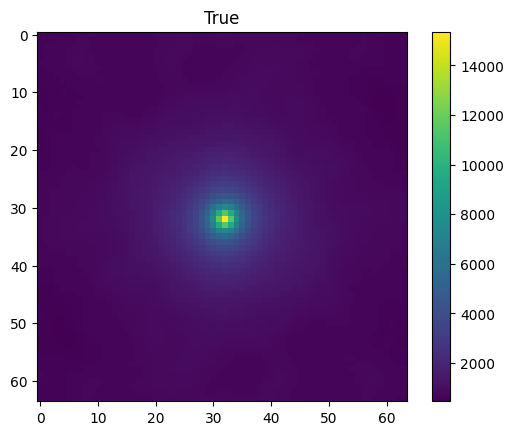

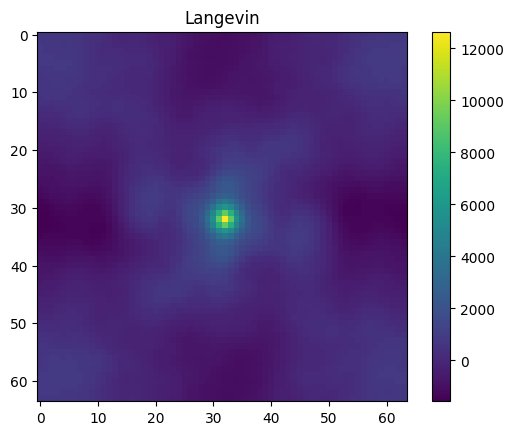

In [36]:
phi_s = wcrg.load_data(W, s[:100], depth, J, show_hist=False)
wcrg.Show_langevin(phi_s, x_64, log=True)

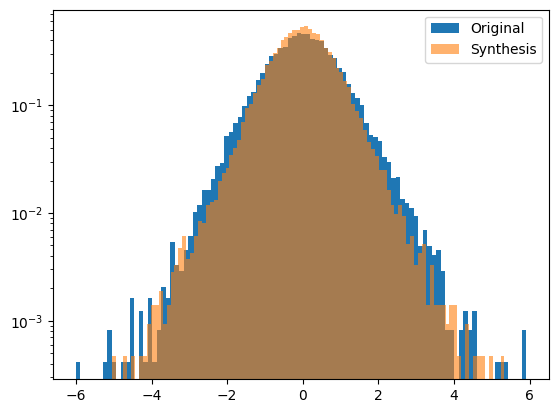

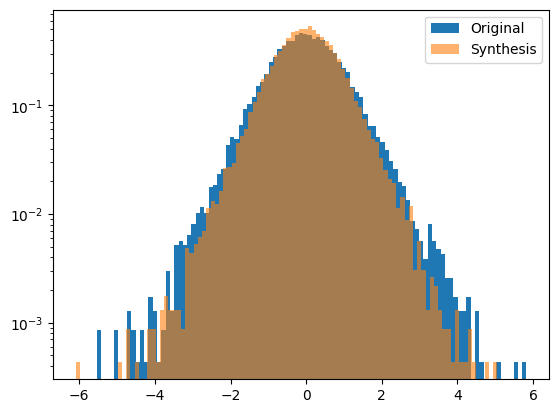

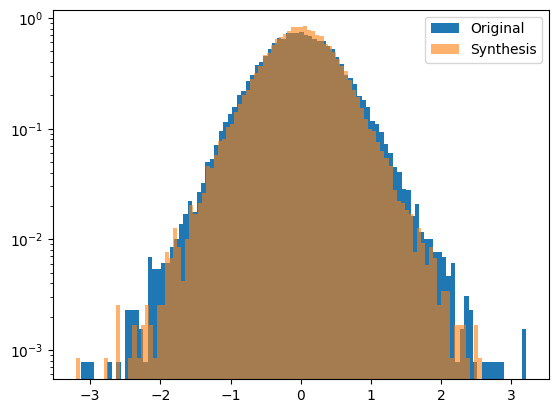

In [37]:
x_high_reco = ansatz.decompose(x_64.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_64)]
wcrg.compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
wcrg.compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
wcrg.compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

### L = 128

In [38]:
J = int(np.log2(d.shape[-1]))
L = 128

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s.float(), depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d.float(), depth, J, show_hist=False)

In [39]:
mask = torch.bitwise_and(torch.max(phi_d.reshape(-1,(L*L)),1)[0]<10, torch.min(phi_d.reshape(-1,(L*L)),1)[0]>-5)
phi_d = phi_d[mask]
phi_s = phi_s[mask]
phi_d.shape, phi_s.shape

(torch.Size([3264, 128, 128]), torch.Size([3264, 128, 128]))

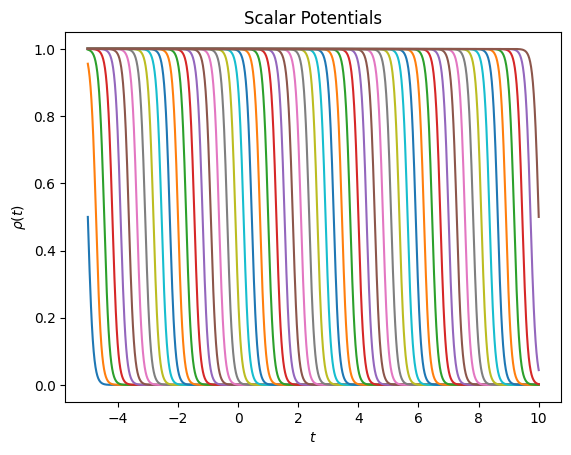

In [40]:
num_potentials = 56

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (2,0),(0,2),(2,2),(2,-2))

centers = torch.linspace(-5, 10, num_potentials).cuda()
sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

wcrg.Plot_Sigmoid(centers, sigma)

mode = 'All'
ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [45]:
dataloader = torch.utils.data.DataLoader(phi_d[:1000], batch_size=20)
wcrg.Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
wcrg.optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/10] loss: 0.0
[0/10] loss: -101.97658
[0/10] loss: -205.16513
[0/10] loss: -304.16354
[0/10] loss: -403.28391
[0/10] loss: -499.4487
[0/10] loss: -596.70642
[0/10] loss: -699.91077
[0/10] loss: -788.5694
[0/10] loss: -871.18811
[0/10] loss: -978.93036
[0/10] loss: -1077.3752
[0/10] loss: -1165.6337
[0/10] loss: -1264.2399
[0/10] loss: -1353.3556
[0/10] loss: -1427.9226
[0/10] loss: -1530.3206
[0/10] loss: -1610.3052
[0/10] loss: -1715.9473
[0/10] loss: -1812.3313
[0/10] loss: -1883.911
[0/10] loss: -1984.9741
[0/10] loss: -2037.0841
[0/10] loss: -2139.0818
[0/10] loss: -2232.0952
[0/10] loss: -2299.4438
[0/10] loss: -2416.1765
[0/10] loss: -2480.1809
[0/10] loss: -2525.2673
[0/10] loss: -2600.7202
[0/10] loss: -2707.1843
[0/10] loss: -2781.8423
[0/10] loss: -2891.7195
[0/10] loss: -2947.3667
[0/10] loss: -3022.6221
[0/10] loss: -3126.4907
[0/10] loss: -3171.6179
[0/10] loss: -3247.7004
[0/10] loss: -3341.9746
[0/10] loss: -3385.6477
[0/10] loss: -3478.3101
[0/10] loss: -3533.3713
[0

[6/10] loss: -10836.155
[6/10] loss: -10847.205
[6/10] loss: -10837.357
[6/10] loss: -10854.076
[6/10] loss: -10791.467
[6/10] loss: -10923.648
[7/10] loss: -10863.094
[7/10] loss: -10818.426
[7/10] loss: -10915.707
[7/10] loss: -10837.716
[7/10] loss: -10836.527
[7/10] loss: -10923.31
[7/10] loss: -10863.01
[7/10] loss: -10867.568
[7/10] loss: -10893.639
[7/10] loss: -10825.566
[7/10] loss: -10970.227
[7/10] loss: -10911.362
[7/10] loss: -10902.652
[7/10] loss: -10944.984
[7/10] loss: -11014.932
[7/10] loss: -10895.044
[7/10] loss: -11024.961
[7/10] loss: -10958.387
[7/10] loss: -11002.006
[7/10] loss: -11066.842
[7/10] loss: -11003.801
[7/10] loss: -11050.304
[7/10] loss: -10962.1
[7/10] loss: -11012.604
[7/10] loss: -11047.122
[7/10] loss: -10913.115
[7/10] loss: -10947.271
[7/10] loss: -11008.779
[7/10] loss: -10958.844
[7/10] loss: -10927.369
[7/10] loss: -11008.967
[7/10] loss: -10996.521
[7/10] loss: -11057.9
[7/10] loss: -11096.758
[7/10] loss: -11040.785
[7/10] loss: -10930.59

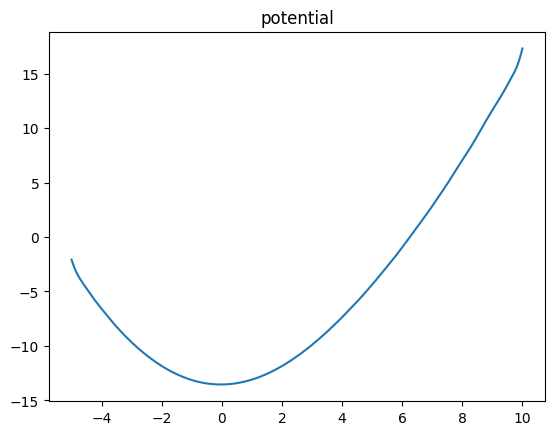

In [46]:
wcrg.Show_Sigmoid(ansatz)

In [48]:
wcrg.save_ansatz(ansatz,L,KEY,dir_mod)

In [47]:
d_condi, d_hf = ansatz.decompose(phi_d[:20])
s_hf = d_hf - ansatz.gradient(d_hf, d_condi, ansatz.theta().detach())[:, 0]
x_128 = ansatz.reconstruct(x_64, s_hf)

In [49]:
wcrg.save(x_128,L,KEY,dir_synth)

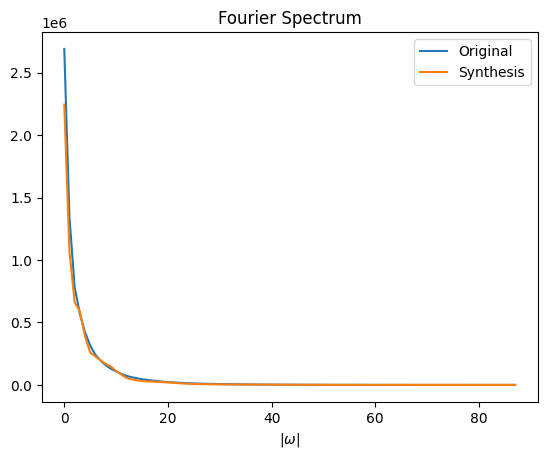

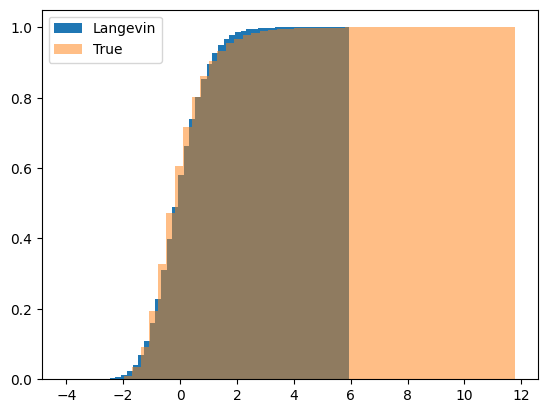

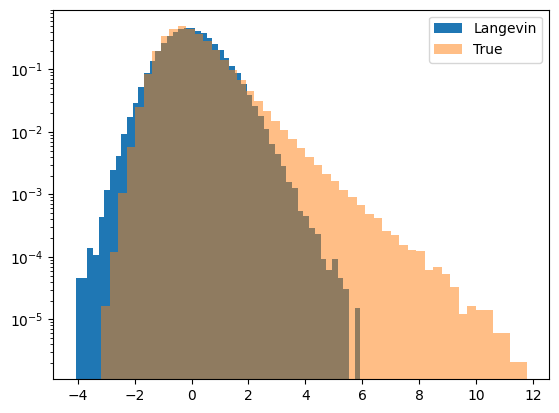

mean_true = tensor(0.0279)
std_true = tensor(0.9997)
mean_langevin = tensor(-8.4576e-05)
std_langevin = tensor(0.8978)


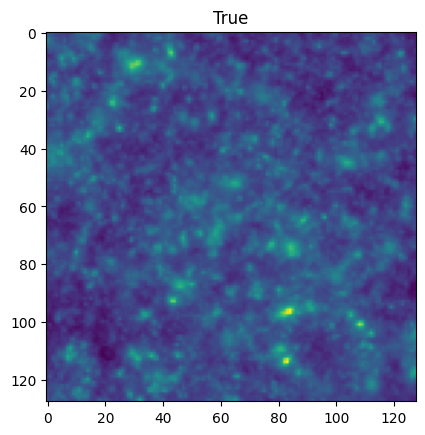

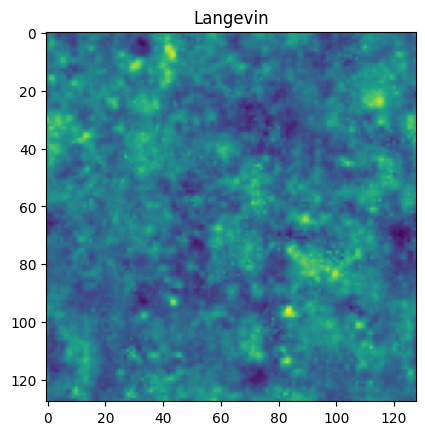

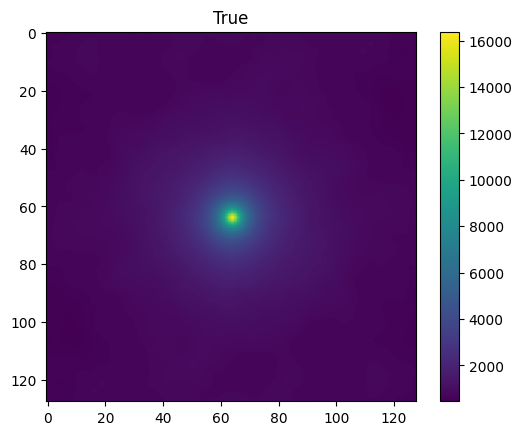

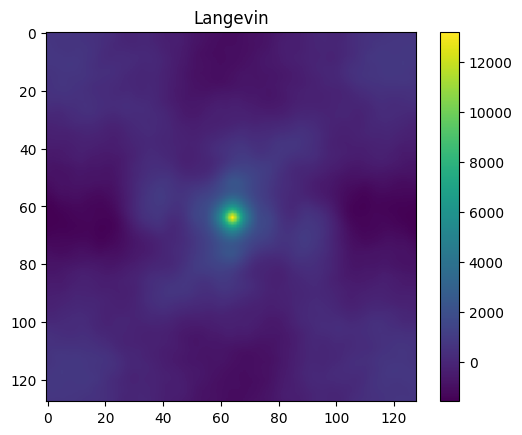

In [50]:
phi_s = wcrg.load_data(W, s[:100], depth, J, show_hist=False)
wcrg.Show_langevin(phi_s, x_128, log=True)

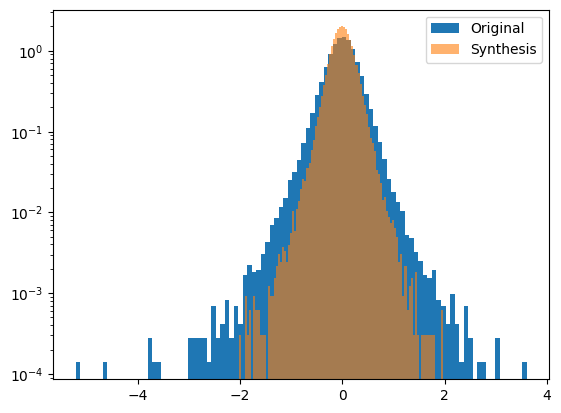

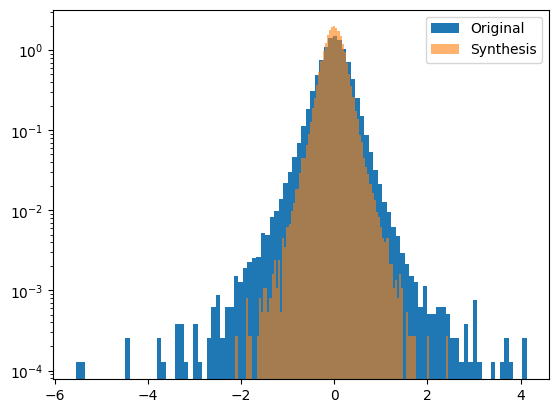

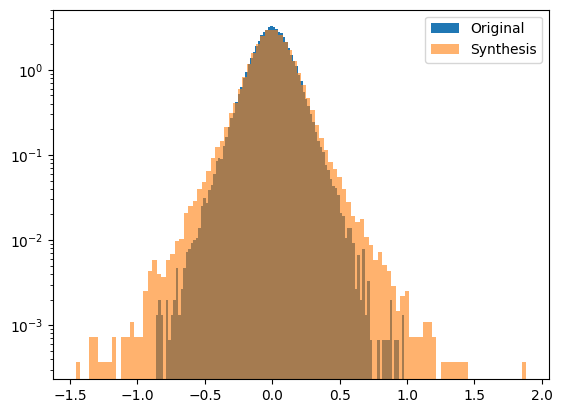

In [51]:
x_high_reco = ansatz.decompose(x_128.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_128)]
wcrg.compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
wcrg.compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
wcrg.compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

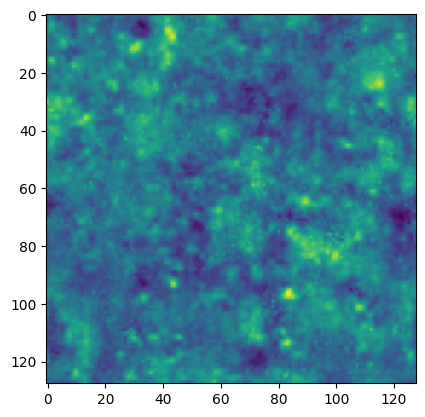

In [52]:
plt.imshow(x_128[0].cpu())
plt.show()